# Generate Results

In [ ]:
!pip install -U piscis==0.2.5 deepblink==0.1.4 matplotlib netcdf4==1.6.5 orbax-checkpoint==0.4.4 pyimagej seaborn tensorflow==2.15.0 tensorstore==0.1.45 zarr

!sudo apt update && sudo apt install -y maven openjdk-8-jre openjdk-11-jre

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.8/493.8 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8

In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import imagej
import json
import matplotlib.pyplot as plt
import nd2
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import subprocess
import sys
import tensorflow as tf
import textwrap
import tifffile
import xarray as xr
import zarr

from deepblink.io import load_model
from deepblink.inference import predict
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import ConnectionPatch, Rectangle
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from pathlib import Path
from scipy import stats
from skimage.measure import block_reduce
from skimage.transform import resize

from piscis import Piscis
from piscis.data import load_datasets
from piscis.downloads import download_dataset
from piscis.metrics import compute_metrics
from piscis.transforms import normalize
from piscis.utils import fit_coords, remove_duplicate_coords, snap_coords

tf.config.set_visible_devices([], 'GPU')

plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
sns.set_style('darkgrid')

In [3]:
# Define path to outputs folder.
outputs_path = Path().absolute().parent / 'outputs'

# Google Colab: use pre-computed outputs folder from GitHub.
if 'google.colab' in sys.modules:

    import subprocess
    from huggingface_hub import HfFileSystem

    subprocess.run(['git', 'clone', 'https://github.com/zjniu/Piscis.git'])
    subprocess.run(['rm', '-R', 'outputs'])
    subprocess.run(['mv', 'Piscis/paper/outputs', '.'])
    subprocess.run(['mv', 'Piscis/paper/8_generate_results/autofluorescence', '.'])
    subprocess.run(['rm', '-R', 'Piscis'])

    fs = HfFileSystem()
    fs.download('wniu/piscis_lfs', '', recursive=True)
    subprocess.run('mv piscis_lfs/* outputs', shell=True)
    subprocess.run(['rm', '-R', 'piscis_lfs'])

    outputs_path = Path().absolute() / 'outputs'

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


wniu/piscis_lfs/.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

wniu/piscis_lfs/README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

(…)ls/231019_030132_20230905_cell_size_1.h5:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

(…)ls/231019_030152_20230905_cell_size_2.h5:   0%|          | 0.00/13.3M [00:00<?, ?B/s]

(…)ls/231019_030223_20230905_cell_size_4.h5:   0%|          | 0.00/20.6M [00:00<?, ?B/s]

wniu/piscis_lfs/rs-fish.jar:   0%|          | 0.00/204M [00:00<?, ?B/s]

In [4]:
# Define path to datasets.
datasets_path = outputs_path / 'datasets'
datasets_path.mkdir(parents=True, exist_ok=True)

# Define path to Piscis datasets.
piscis_datasets_path = datasets_path / 'piscis'
piscis_datasets_path.mkdir(parents=True, exist_ok=True)

# Define path to deepBlink datasets.
deepblink_datasets_path = datasets_path / 'deepblink'
deepblink_datasets_path.mkdir(parents=True, exist_ok=True)

# Define path to deepBlink models.
deepblink_models_path = outputs_path / 'deepblink_models'

# Define path to benchmarks.
benchmarks_path = outputs_path / 'benchmarks'

# Define path to panels.
panels_path = outputs_path / 'panels'
panels_path.mkdir(parents=True, exist_ok=True)

# Define path to temporary folder.
tmp_path = Path('tmp')
tmp_path.mkdir(parents=True, exist_ok=True)

In [5]:
# Define useful functions.
def barplot(dfs, title, x, y, hue=None, significance=True, ymax=float('inf'), ylim=None, yticks=None, text_padding=0):

    """
    Adapted from https://rowannicholls.github.io/python/graphs/ax_based/boxplots_significance.html.
    """

    fig, ax = plt.subplots()
    concat_df = pd.concat(dfs)
    if hue is None:
        sns.barplot(data=concat_df, x=concat_df[x], y=concat_df[y], ax=ax)
    else:
        sns.barplot(data=concat_df, x=concat_df[x], y=concat_df[y], hue=concat_df[hue], ax=ax)
    ax.set_title(title, fontsize=16, fontweight='bold', wrap=True)
    ax.set_xlabel(x, fontsize=14)
    ax.set_ylabel(y, fontsize=14)
    ax.tick_params(axis='x', which='major', labelsize=12, length=0)
    xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
    ax.set_xticks(xticks[:-1], minor=True)
    ax.tick_params(axis='y', which='major', labelsize=12, length=0)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', label_type='center', fontsize=12, fontweight='bold', c='white')

    if significance:

        # Check for statistical significance.
        significant_combinations = []
        combinations = [(0, i) for i in range(1, len(dfs))]
        for c in combinations:
            df1 = dfs[c[0]]
            df2 = dfs[c[1]]
            p = stats.wilcoxon(df1[y], df2[y], alternative='greater').pvalue
            if p < 0.05:
                significant_combinations.append([c, p])

        bottom, top = ax.get_ylim()
        yrange = top - bottom

        # Plot significance bars.
        for i, significant_combination in enumerate(significant_combinations):
            x0 = significant_combination[0][0]
            x1 = significant_combination[0][1]
            level = len(significant_combinations) - i
            bar_height = (yrange * 0.04 * level) + top - yrange * 0.06
            bar_tips = bar_height - (yrange * 0.01)
            p = significant_combination[1]
            text = ax.text((x0 + x1) * 0.5, bar_height, f'{p:.2e}', ha='center', va='center', c='k', fontsize=10)
            window_extent = text.get_window_extent()
            window_extent = window_extent.transformed(ax.transData.inverted())
            ax.plot([x0, x0, window_extent.x0 - window_extent.width * text_padding], [bar_tips, bar_height, bar_height], lw=1.5, c='k')
            ax.plot([window_extent.x1 + window_extent.width * text_padding, x1, x1], [bar_height, bar_height, bar_tips], lw=1.5, c='k')

   # Adjust y-axis.
    if yticks is None:
        yticks = ax.get_yticks()
        yticks = [ytick for ytick in ax.get_yticks() if ytick <= ymax][1:]
    ax.set_yticks(yticks)
    if ylim is None:
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + yrange * 0.02)
    else:
        ax.set_ylim(*ylim)

    return fig, ax

def to_rgb(image, fish_lower=0, fish_upper=100, dapi_lower=0, dapi_upper=100):

    fish_image, dapi_image = image
    fish_image = np.clip(normalize(fish_image, fish_lower, fish_upper), 0, 1)
    dapi_image = np.clip(normalize(dapi_image, dapi_lower, dapi_upper), 0, 1)
    fish_image = np.rint(255 * fish_image).astype(int)
    dapi_image = np.rint(255 * dapi_image).astype(int)
    rgb_image = np.stack((fish_image, np.zeros(image.shape[1:], dtype=int), dapi_image), axis=-1)

    return rgb_image

def strip_axes(ax, ticks=True, ticklabels=True, spine=True):

    if ticks:
        ax.set_xticks([])
        ax.set_yticks([])
    if ticklabels:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    if spine:
        for spine in ax.spines.values():
            spine.set_visible(False)

In [6]:
# Define a colormap that goes from black to red.
black_red = LinearSegmentedColormap.from_list('black_red', [(0, 0, 0), (1, 0, 0)], N=256)

In [7]:
# Initialize FIJI environment.
!sudo update-alternatives --set java /usr/lib/jvm/java-11-openjdk-amd64/bin/java
ij = imagej.init('sc.fiji:fiji')
!sudo update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


In [8]:
# Define the Groovy script for running Trackmate.
script = """
//@double radius
//@double threshold

System.out = new PrintStream(new OutputStream() {
    public void write(int b) {
        // NO-OP
    }
})

import ij.IJ
import fiji.plugin.trackmate.Model
import fiji.plugin.trackmate.Settings
import fiji.plugin.trackmate.TrackMate
import fiji.plugin.trackmate.detection.LogDetectorFactory

// Assume you want the current image or specify path with IJ.openImage(path)
imp = IJ.openImage('tmp/image.tif')

import fiji.plugin.trackmate.Model
import fiji.plugin.trackmate.Settings
import fiji.plugin.trackmate.TrackMate

import fiji.plugin.trackmate.detection.LogDetectorFactory

// Swap Z and T dimensions if T=1
dims = imp.getDimensions() // default order: XYCZT
if (dims[4] == 1) {
    imp.setDimensions(dims[2], dims[4], dims[3])
}

// Setup settings for TrackMate
settings = new Settings(imp)

settings.detectorFactory = new LogDetectorFactory()
settings.detectorSettings = settings.detectorFactory.getDefaultSettings()
settings.detectorSettings['RADIUS'] = radius
settings.detectorSettings['THRESHOLD'] = threshold

// Run TrackMate for spot detection
model = new Model()
trackmate = new TrackMate(model, settings)

trackmate.process()

// Get spots and their coordinates
spots = model.getSpots().iterable(true)
spotCoordinates = []

spots.each { spot ->
    coord = [spot.getDoublePosition(0).toString(), spot.getDoublePosition(1).toString(), spot.getDoublePosition(2).toString()]
    spotCoordinates.add(coord)
}

spotCoordinates
"""

In [9]:
# Define the base command for running RS-FISH.
base_command = [
    'java',
    '-cp',
    str(outputs_path / 'rs-fish.jar'),
    '-Xmx20G',
    '-Dspark.driver.extraJavaOptions=-Dlog4j.configuration=file:/path/to/log4j.properties',
    '-Dspark.master=local[8]',
    'net.preibisch.rsfish.spark.SparkRSFISH',
    f"--image={str(tmp_path / 'dataset.n5')}",
    '--minIntensity=0',
    '--maxIntensity=1',
    '--anisotropy=1.0',
    f"--output={str(tmp_path / 'output.csv')}",
]

In [10]:
# Define the Piscis dataset.
dataset = '20230905'
dataset_path = piscis_datasets_path / dataset

# Define path to raw images.
images_path = dataset_path / 'raw' / 'images'

# Define path to save datasets with DAPI.
with_dapi_path = dataset_path / 'with_dapi'

In [11]:
# Download the Piscis dataset.
if not dataset_path.is_dir():
    download_dataset(dataset, piscis_datasets_path, minimal_download=False)

(…)ld_Seq0000_crop1to1407_14Jan2019_CY5.npz:   0%|          | 0.00/2.15M [00:00<?, ?B/s]

(…)API,CY3,A594,Brightfield_Seq0001_CY3.npz:   0%|          | 0.00/4.32M [00:00<?, ?B/s]

(…)ts/wniu/Piscis/20230905/A3_GFP1_A594.npz:   0%|          | 0.00/9.13M [00:00<?, ?B/s]

(…)ets/wniu/Piscis/20230905/A3_GFP1_CY3.npz:   0%|          | 0.00/3.55M [00:00<?, ?B/s]

(…)ets/wniu/Piscis/20230905/A3_GFP1_CY5.npz:   0%|          | 0.00/5.26M [00:00<?, ?B/s]

(…)PI,A594,YFP,Brightfield_Seq0000_A594.npz:   0%|          | 0.00/4.23M [00:00<?, ?B/s]

(…)PI_DMin,CY3,A594,CY5,CY7_Seq0000_CY5.npz:   0%|          | 0.00/2.75M [00:00<?, ?B/s]

(…)/20230905/combined/20230905_combined.npz:   0%|          | 0.00/158M [00:00<?, ?B/s]

(…)u/Piscis/20230905/microtubule_subset.npz:   0%|          | 0.00/4.04M [00:00<?, ?B/s]

(…)wniu/Piscis/20230905/particle_subset.npz:   0%|          | 0.00/15.8M [00:00<?, ?B/s]

(…)field_Seq0000_crop1to1407_14Jan2019.json:   0%|          | 0.00/750k [00:00<?, ?B/s]

(…)elDAPI,CY3,A594,Brightfield_Seq0001.json:   0%|          | 0.00/1.88M [00:00<?, ?B/s]

(…)is/20230905/raw/annotations/A3_GFP1.json:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

(…)elDAPI,A594,YFP,Brightfield_Seq0000.json:   0%|          | 0.00/542k [00:00<?, ?B/s]

(…)lDAPI_DMin,CY3,A594,CY5,CY7_Seq0000.json:   0%|          | 0.00/59.4k [00:00<?, ?B/s]

(…)230905/raw/annotations/untreated014.json:   0%|          | 0.00/219k [00:00<?, ?B/s]

(…)htfield_Seq0000_crop1to1407_14Jan2019.nc:   0%|          | 0.00/4.21M [00:00<?, ?B/s]

(…)nnelDAPI,CY3,A594,Brightfield_Seq0001.nc:   0%|          | 0.00/8.40M [00:00<?, ?B/s]

(…)iu/Piscis/20230905/raw/images/A3_GFP1.nc:   0%|          | 0.00/151M [00:00<?, ?B/s]

(…)nnelDAPI,A594,YFP,Brightfield_Seq0000.nc:   0%|          | 0.00/8.40M [00:00<?, ?B/s]

(…)nelDAPI_DMin,CY3,A594,CY5,CY7_Seq0000.nc:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

(…)scis/20230905/raw/images/untreated014.nc:   0%|          | 0.00/68.1M [00:00<?, ?B/s]

(…)wniu/Piscis/20230905/receptor_subset.npz:   0%|          | 0.00/4.04M [00:00<?, ?B/s]

(…)iu/Piscis/20230905/untreated014_A594.npz:   0%|          | 0.00/3.44M [00:00<?, ?B/s]

(…)niu/Piscis/20230905/untreated014_CY5.npz:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

(…)/wniu/Piscis/20230905/vesicle_subset.npz:   0%|          | 0.00/4.06M [00:00<?, ?B/s]

(…)_crop1to1407_14Jan2019_CY5_with_dapi.npz:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

(…)94,Brightfield_Seq0001_CY3_with_dapi.npz:   0%|          | 0.00/8.51M [00:00<?, ?B/s]

(…)905/with_dapi/A3_GFP1_A594_with_dapi.npz:   0%|          | 0.00/18.2M [00:00<?, ?B/s]

(…)0905/with_dapi/A3_GFP1_CY3_with_dapi.npz:   0%|          | 0.00/7.08M [00:00<?, ?B/s]

(…)0905/with_dapi/A3_GFP1_CY5_with_dapi.npz:   0%|          | 0.00/10.5M [00:00<?, ?B/s]

(…)P,Brightfield_Seq0000_A594_with_dapi.npz:   0%|          | 0.00/8.42M [00:00<?, ?B/s]

(…)3,A594,CY5,CY7_Seq0000_CY5_with_dapi.npz:   0%|          | 0.00/5.50M [00:00<?, ?B/s]

(…)ith_dapi/untreated014_A594_with_dapi.npz:   0%|          | 0.00/6.88M [00:00<?, ?B/s]

(…)with_dapi/untreated014_CY5_with_dapi.npz:   0%|          | 0.00/23.3M [00:00<?, ?B/s]

In [12]:
# Download the deepBlink datasets.

# Define the URL for the Figshare API.
api_url = f'https://api.figshare.com/v2/articles/12958037'

# Get a list of files from Figshare.
files = requests.get(api_url).json()['files']

for file in files:
    file_name = file['name']
    if file_name.endswith('.npz'):
        download_url = file['download_url']
        response = requests.get(download_url, stream=True)
        response.raise_for_status()
        deepblink_dataset_path = deepblink_datasets_path / file_name
        if not deepblink_dataset_path.exists():
            with open(deepblink_dataset_path, 'wb') as handle:
                for block in response.iter_content(1024):
                    handle.write(block)

In [13]:
# Download the deepBlink models.

# Define the URL for the Figshare API.
api_url = f'https://api.figshare.com/v2/articles/12958127'

# Get a list of files from Figshare.
files = requests.get(api_url).json()['files']

# Loop through files and download.
for file in files:
    file_name = file['name']
    if file_name.startswith('deepblink'):
        download_url = file['download_url']
        response = requests.get(download_url, stream=True)
        response.raise_for_status()
        deepblink_model_path = deepblink_models_path / file_name
        if not deepblink_model_path.exists():
            with open(deepblink_model_path, 'wb') as handle:
                for block in response.iter_content(1024):
                    handle.write(block)

In [14]:
# Load the Piscis model.
piscis_model = Piscis(model_name=dataset, batch_size=1)

# Load the deepBlink model.
for deepblink_model_path in deepblink_models_path.glob(f'*{dataset}*.h5'):
    if deepblink_model_path.stem[-1] == '2':
        deepblink_model = load_model(deepblink_model_path)
    if deepblink_model_path.stem[-1] == '4':
        deepblink_model_4 = load_model(deepblink_model_path)

wniu/Piscis/models/20230905:   0%|          | 0.00/29.9M [00:00<?, ?B/s]

### Spot omission.

In [15]:
# List subdatasets within the composite dataset.
subdataset_paths = Path(with_dapi_path).glob('*.npz')

dataset_images = {}
dataset_coords = {}
dataset_fractions_omitted = {}
for subdataset_path in subdataset_paths:

    subdataset = subdataset_path.stem.split('_with_dapi')[0]

    # Load the dataset.
    ds = load_datasets(subdataset_path, adjustment=None, load_train=True, load_valid=True, load_test=True)
    coords = np.concatenate([split['coords'] for split in ds.values()])
    mask = np.argwhere(np.array([len(coord) for coord in coords]) >= 10).ravel()
    coords = coords[mask]
    images = np.concatenate([split['images'] for split in ds.values()])[mask]

    # Calculate the fractions of spots omitted by 4x4 grid cells.
    fractions_omitted = []
    for coord in coords:
        rounded_coord = np.rint(coord - 0.5).astype(int)
        labels = np.zeros((256, 256), dtype=bool)
        labels[rounded_coord[:, 0], rounded_coord[:, 1]] = True
        labels = block_reduce(labels, (4, 4), np.max)
        fraction_omitted = 1 - np.sum(labels) / len(coord)
        fractions_omitted.append(fraction_omitted)

    dataset_images[subdataset] = images
    dataset_coords[subdataset] = coords
    dataset_fractions_omitted[subdataset] = fractions_omitted

[108, 54, 32, 16, 7, 1, 2]


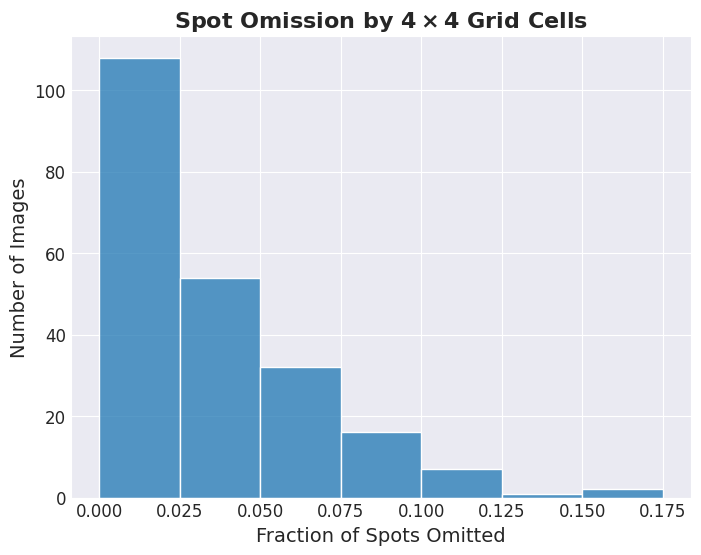

In [16]:
# Plot histogram for spot omission across.
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot([fraction_omitted for fractions_omitted in dataset_fractions_omitted.values() for fraction_omitted in fractions_omitted], bins=7, binrange=(0, 0.175), ax=ax)
ax.set_title(r'Spot Omission by $\mathbf{4\times 4}$ Grid Cells', fontsize=16, fontweight='bold')
ax.set_xlabel('Fraction of Spots Omitted', fontsize=14)
ax.set_ylabel('Number of Images', fontsize=14)
ax.tick_params(axis='x', which='major', labelsize=12, length=0)
ax.tick_params(axis='y', which='major', labelsize=12, length=0)
fig.savefig(panels_path / 'spot_omission_histogram.pdf')
bin_heights = [patch.get_height() for patch in ax.patches]
print(bin_heights)

In [17]:
# Choose spot omission example image 1.
spot_omission_image = dataset_images['A3_GFP1_A594'][26]
spot_omission_rgb_image = to_rgb(spot_omission_image, 25, 99.9, 25, 100)
spot_omission_coord = dataset_coords['A3_GFP1_A594'][26]
spot_omission_xlim, spot_omission_ylim = (187.5, 212.5), (64.5, 39.5)

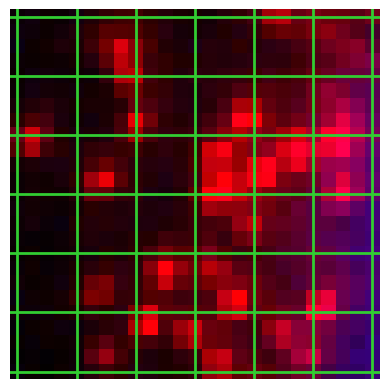

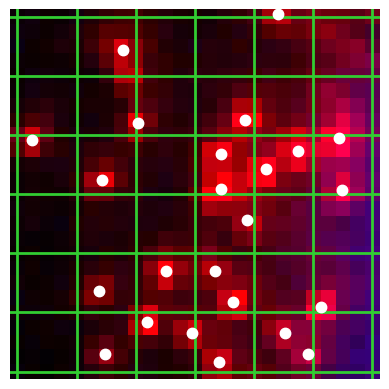

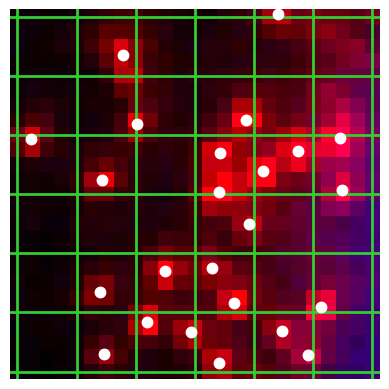

1/1 [==============================] - 2s 2s/step


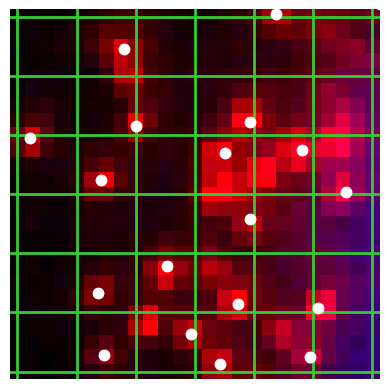

In [18]:
# Show spot omission example image 1.
fig, ax = plt.subplots()
ax.imshow(spot_omission_rgb_image, interpolation='none')
ax.set_xlim(spot_omission_xlim)
ax.set_ylim(spot_omission_ylim)
ax.hlines(y=np.arange(0, 257, 4), xmin=-0.5, xmax=255.5, colors='limegreen', linewidth=2)
ax.vlines(x=np.arange(0, 257, 4), ymin=-0.5, ymax=255.5, colors='limegreen', linewidth=2)
strip_axes(ax)
fig.savefig(panels_path / 'spot_omission_example_1.pdf')
display(fig)

# Show spot omission example image 1 with ground truth annotations.
scatter = ax.plot(spot_omission_coord[:, 1], spot_omission_coord[:, 0], '.', c='white', markersize=15)
fig.savefig(panels_path / 'spot_omission_example_1_ground_truth.pdf')
display(fig)
for point in scatter:
    point.remove()

# Show spot omission example image 1 with Piscis predictions.
spot_omission_coord_pred = piscis_model.predict(spot_omission_image[0])
scatter = ax.plot(spot_omission_coord_pred[:, 1], spot_omission_coord_pred[:, 0], '.', c='white', markersize=15)
fig.savefig(panels_path / 'spot_omission_example_1_piscis.pdf')
display(fig)
for point in scatter:
    point.remove()

# Show spot omission example image 1 with deepBlink predictions.
spot_omission_coord_pred = predict(spot_omission_image[0], deepblink_model_4)
scatter = ax.plot(spot_omission_coord_pred[:, 1], spot_omission_coord_pred[:, 0], '.', c='white', markersize=15)
fig.savefig(panels_path / 'spot_omission_example_1_deepblink.pdf')

In [19]:
# Choose spot omission example image 2.
spot_omission_image = dataset_images['A3_GFP1_CY5'][6]
spot_omission_rgb_image = to_rgb(spot_omission_image, 25, 99.9, 25, 100)
spot_omission_coord = dataset_coords['A3_GFP1_CY5'][6]
spot_omission_xlim, spot_omission_ylim = (199.5, 224.5), (148.5, 123.5)

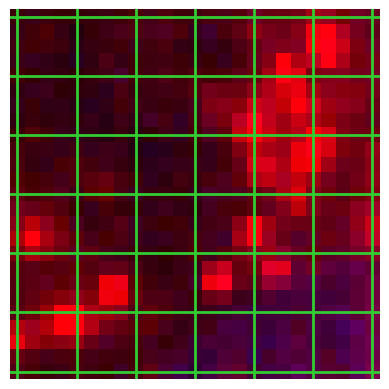

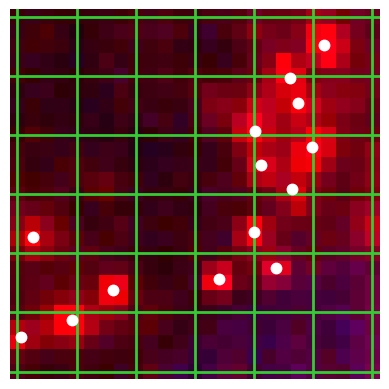

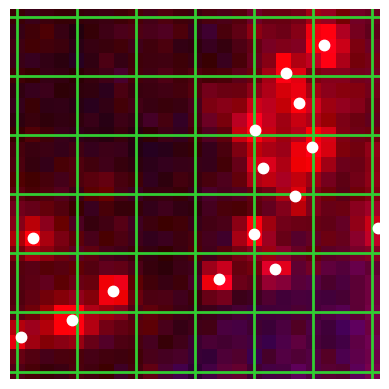

1/1 [==============================] - 0s 356ms/step


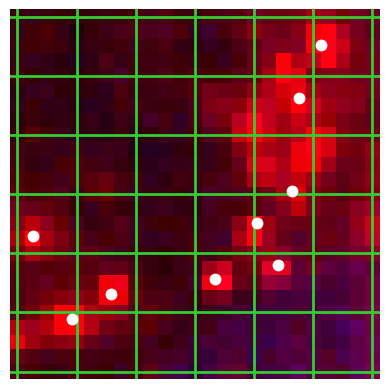

In [20]:
# Show spot omission example image 2.
fig, ax = plt.subplots()
ax.imshow(spot_omission_rgb_image, interpolation='none')
ax.set_xlim(spot_omission_xlim)
ax.set_ylim(spot_omission_ylim)
ax.hlines(y=np.arange(0, 257, 4), xmin=-0.5, xmax=255.5, colors='limegreen', linewidth=2)
ax.vlines(x=np.arange(0, 257, 4), ymin=-0.5, ymax=255.5, colors='limegreen', linewidth=2)
strip_axes(ax)
fig.savefig(panels_path / 'spot_omission_example_2.pdf')
display(fig)

# Show spot omission example image 2 with ground truth annotations.
scatter = ax.plot(spot_omission_coord[:, 1], spot_omission_coord[:, 0], '.', c='white', markersize=15)
fig.savefig(panels_path / 'spot_omission_example_2_ground_truth.pdf')
display(fig)
for point in scatter:
    point.remove()

# Show spot omission example image 2 with Piscis predictions.
spot_omission_coord_pred = piscis_model.predict(spot_omission_image[0])
scatter = ax.plot(spot_omission_coord_pred[:, 1], spot_omission_coord_pred[:, 0], '.', c='white', markersize=15)
fig.savefig(panels_path / 'spot_omission_example_2_piscis.pdf')
display(fig)
for point in scatter:
    point.remove()

# Show spot omission example image 2 with deepBlink predictions.
spot_omission_coord_pred = predict(spot_omission_image[0], deepblink_model_4)
scatter = ax.plot(spot_omission_coord_pred[:, 1], spot_omission_coord_pred[:, 0], '.', c='white', markersize=15)
fig.savefig(panels_path / 'spot_omission_example_2_deepblink.pdf')

### Benchmarks.

In [21]:
# Load benchmarks.
with open(benchmarks_path / 'piscis_f1s.json', 'r') as f:
    piscis_f1s = json.load(f)
with open(benchmarks_path / 'piscis_dice_f1s.json', 'r') as f:
    piscis_dice_f1s = json.load(f)
with open(benchmarks_path / 'piscis_bce_f1s.json', 'r') as f:
    piscis_bce_f1s = json.load(f)
with open(benchmarks_path / 'piscis_focal_f1s.json', 'r') as f:
    piscis_focal_f1s = json.load(f)
with open(benchmarks_path / 'deepblink_f1s.json', 'r') as f:
    deepblink_f1s = json.load(f)
with open(benchmarks_path / 'trackmate_f1s.json', 'r') as f:
    trackmate_f1s = json.load(f)
with open(benchmarks_path / 'rs_fish_f1s.json', 'r') as f:
    rs_fish_f1s = json.load(f)

piscis_dataset_f1s = np.array([b for a in piscis_f1s[dataset].values() for b in a])
piscis_dice_dataset_f1s = np.array([b for a in piscis_dice_f1s[dataset].values() for b in a])
piscis_bce_dataset_f1s = np.array([b for a in piscis_bce_f1s[dataset].values() for b in a])
piscis_focal_dataset_f1s = np.array([b for a in piscis_focal_f1s[dataset].values() for b in a])
deepblink_cell_size_1_dataset_f1s = np.array([b for a in deepblink_f1s[dataset].values() for b in a['cell_size_1']])
deepblink_cell_size_2_dataset_f1s = np.array([b for a in deepblink_f1s[dataset].values() for b in a['cell_size_2']])
deepblink_cell_size_4_dataset_f1s = np.array([b for a in deepblink_f1s[dataset].values() for b in a['cell_size_4']])
trackmate_dataset_f1s = np.array([[list(c.values()) for c in b.values()] for a in trackmate_f1s.values() for b in a.values()])
rs_fish_dataset_f1s = np.array([[list(c.values()) for c in b.values()] for a in rs_fish_f1s.values() for b in a.values()])

In [22]:
# Find the best cell size for deepBlink on the Piscis dataset.
best_cell_size_index = np.argmax((np.mean(deepblink_cell_size_1_dataset_f1s), np.mean(deepblink_cell_size_2_dataset_f1s), np.mean(deepblink_cell_size_4_dataset_f1s)))
deepblink_dataset_f1s = (deepblink_cell_size_1_dataset_f1s, deepblink_cell_size_2_dataset_f1s, deepblink_cell_size_4_dataset_f1s)[best_cell_size_index]
best_cell_size = (1, 2, 4)[best_cell_size_index]
best_cell_size

2

In [23]:
# Take the parameter combinations that maximize the F1 score per image.
trackmate_dataset_f1s_per_image = np.max(trackmate_dataset_f1s, axis=(1, 2))
rs_fish_dataset_f1s_per_image = np.max(rs_fish_dataset_f1s, axis=(1, 2))

# Take the parameter combination that maximizes the mean F1 score over all images.
trackmate_dataset_f1s_global = trackmate_dataset_f1s.reshape(trackmate_dataset_f1s.shape[0], -1)[:, np.argmax(np.sum(trackmate_dataset_f1s, axis=0))]
rs_fish_dataset_f1s_global = rs_fish_dataset_f1s.reshape(rs_fish_dataset_f1s.shape[0], -1)[:, np.argmax(np.sum(rs_fish_dataset_f1s, axis=0))]

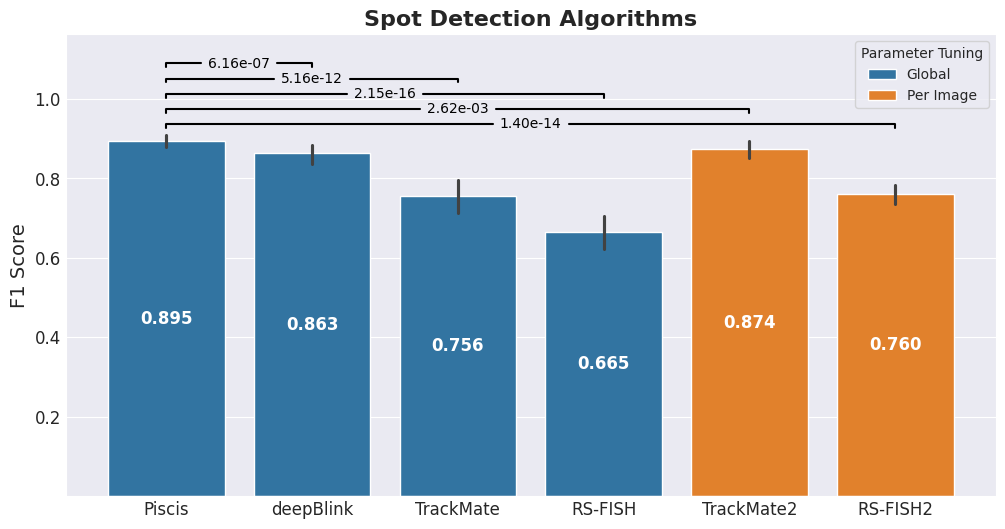

In [24]:
# Plot comparison of spot detection algorithms on Piscis dataset.
piscis_df = pd.DataFrame({
    'Algorithm': ['Piscis'] * len(piscis_dataset_f1s),
    'F1 Score': piscis_dataset_f1s,
    'Parameter Tuning': ['Global'] * len(piscis_dataset_f1s)
})
deepblink_df = pd.DataFrame({
    'Algorithm': ['deepBlink'] * len(deepblink_dataset_f1s),
    'F1 Score': deepblink_dataset_f1s,
    'Parameter Tuning': ['Global'] * len(deepblink_dataset_f1s)
})
trackmate_df_global = pd.DataFrame({
    'Algorithm': ['TrackMate'] * len(trackmate_dataset_f1s_global),
    'F1 Score': trackmate_dataset_f1s_global,
    'Parameter Tuning': ['Global'] * len(trackmate_dataset_f1s_global)
})
rs_fish_df_global = pd.DataFrame({
    'Algorithm': ['RS-FISH'] * len(rs_fish_dataset_f1s_global),
    'F1 Score': rs_fish_dataset_f1s_global,
    'Parameter Tuning': ['Global'] * len(rs_fish_dataset_f1s_global)
})
trackmate_df_per_image = pd.DataFrame({
    'Algorithm': ['TrackMate2'] * len(trackmate_dataset_f1s_per_image),
    'F1 Score': trackmate_dataset_f1s_per_image,
    'Parameter Tuning': ['Per Image'] * len(trackmate_dataset_f1s_per_image)
})
rs_fish_df_per_image = pd.DataFrame({
    'Algorithm': ['RS-FISH2'] * len(rs_fish_dataset_f1s_per_image),
    'F1 Score': rs_fish_dataset_f1s_per_image,
    'Parameter Tuning': ['Per Image'] * len(rs_fish_dataset_f1s_per_image)
})
fig, ax = barplot(
    [piscis_df, deepblink_df, trackmate_df_global, rs_fish_df_global, trackmate_df_per_image, rs_fish_df_per_image],
    title='Spot Detection Algorithms',
    x='Algorithm',
    y='F1 Score',
    hue='Parameter Tuning',
    ymax=1.0 + 1e-7,
    text_padding=-0.15
)
ax.set_xlabel('')
fig.set_size_inches(12, 6)
fig.savefig(panels_path / 'comparison_algorithms.pdf')

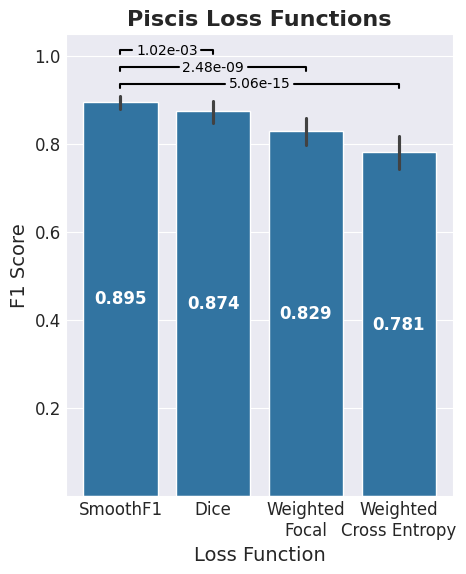

In [25]:
# Plot comparison of Piscis loss functions.
piscis_df = pd.DataFrame({
    'Loss Function': ['SmoothF1'] * len(piscis_dataset_f1s),
    'F1 Score': piscis_dataset_f1s
})
piscis_dice_df = pd.DataFrame({
    'Loss Function': ['Dice'] * len(piscis_dice_dataset_f1s),
    'F1 Score': piscis_dice_dataset_f1s
})
piscis_bce_df = pd.DataFrame({
    'Loss Function': ['Weighted\nCross Entropy'] * len(piscis_dice_dataset_f1s),
    'F1 Score': piscis_bce_dataset_f1s
})
piscis_focal_df = pd.DataFrame({
    'Loss Function': ['Weighted\nFocal'] * len(piscis_focal_dataset_f1s),
    'F1 Score': piscis_focal_dataset_f1s
})
fig, ax = barplot(
    [piscis_df, piscis_dice_df, piscis_focal_df, piscis_bce_df],
    title='Piscis Loss Functions',
    x='Loss Function',
    y='F1 Score',
    ymax=1.0 + 1e-7,
    ylim=(0, 1.05),
    yticks=np.linspace(0.2, 1, 5),
    text_padding=0.25
)
fig.set_size_inches(5, 6)
fig.savefig(panels_path / 'comparison_piscis_loss_functions.pdf')

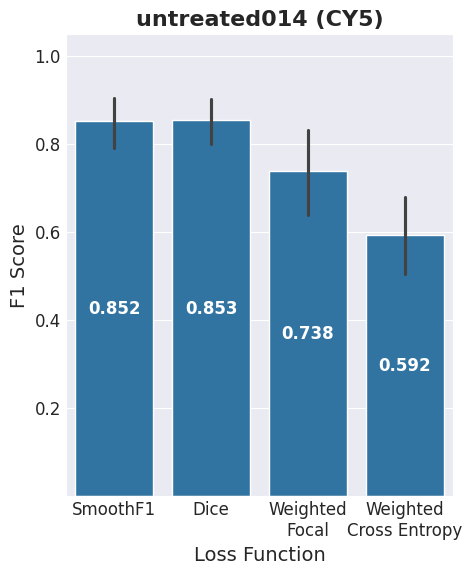

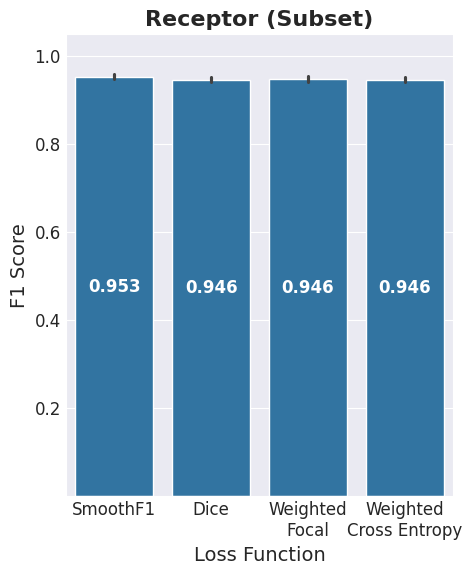

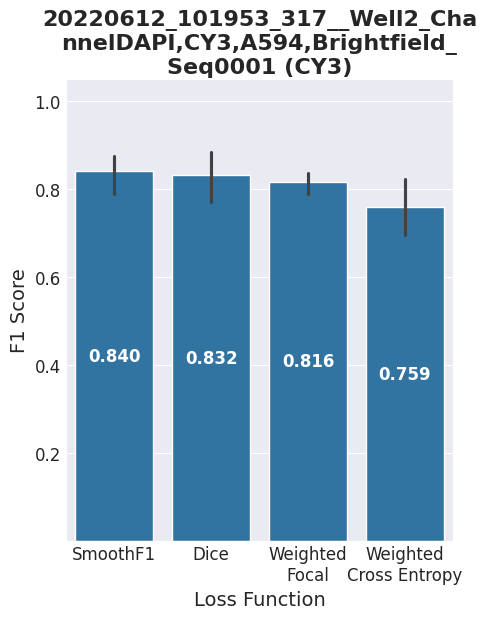

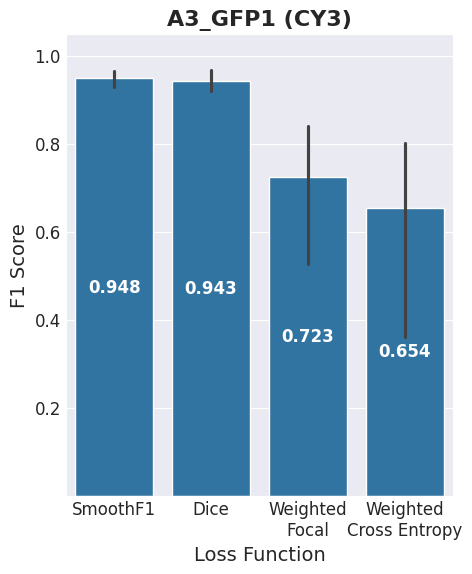

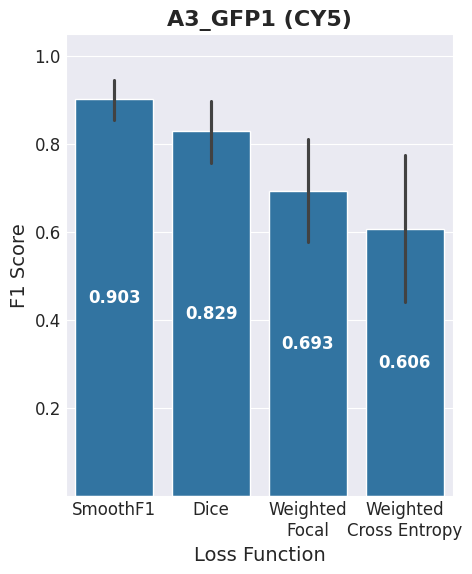

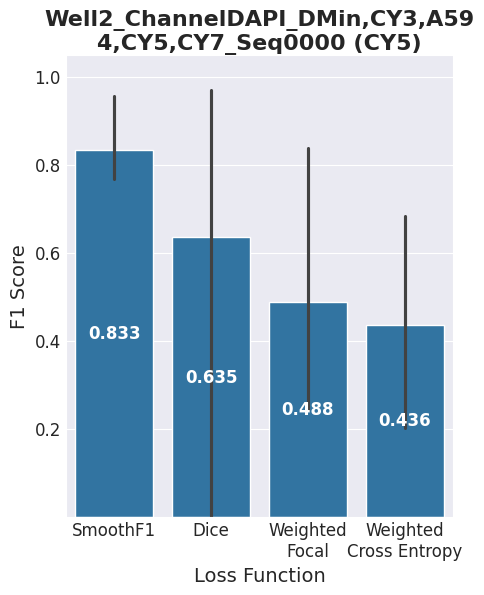

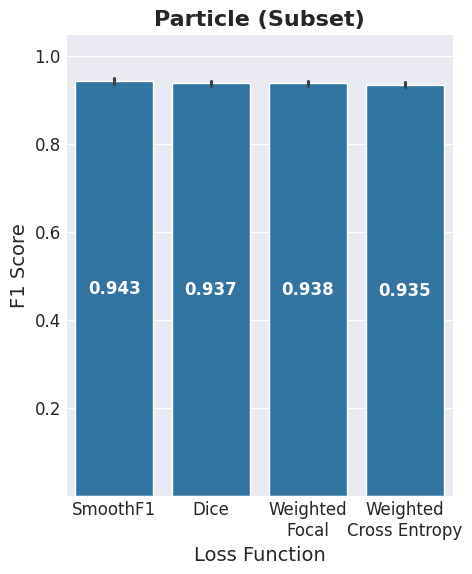

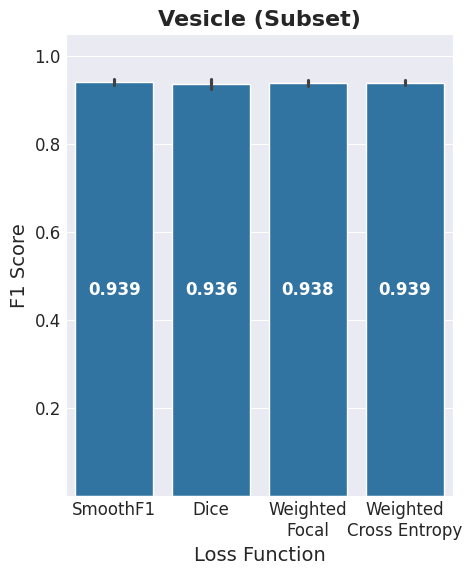

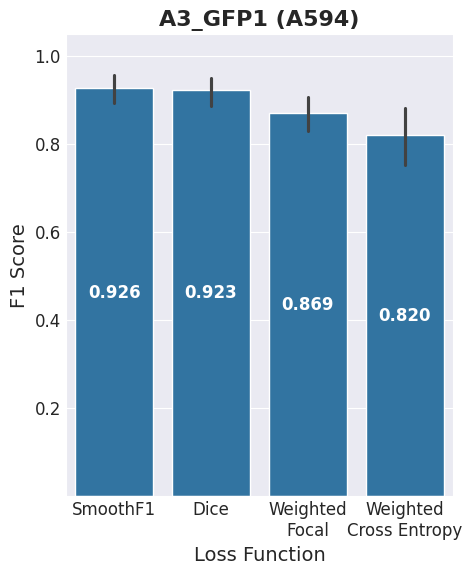

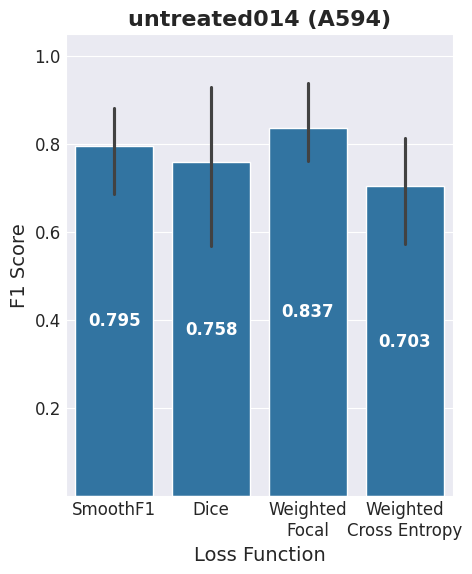

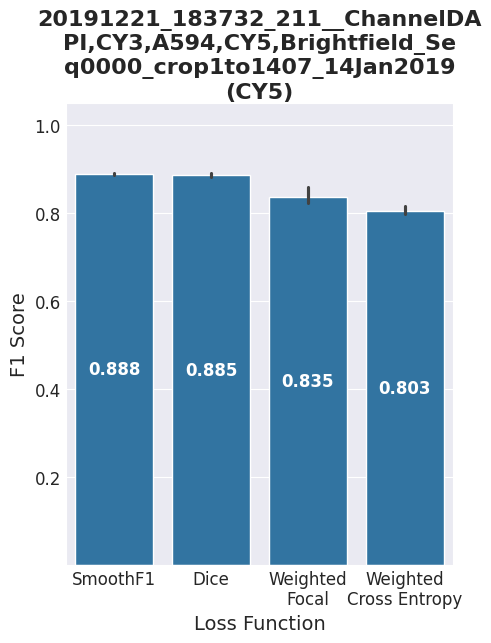

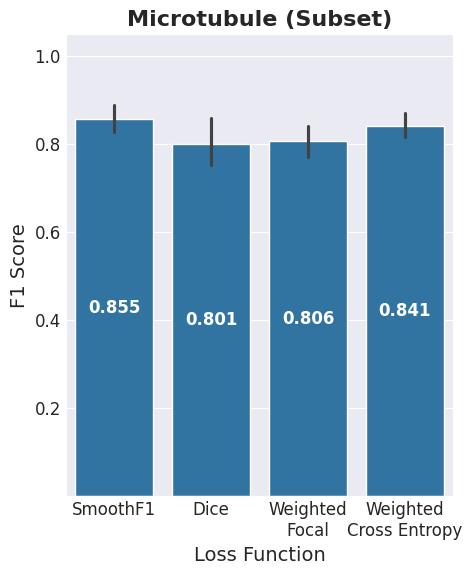

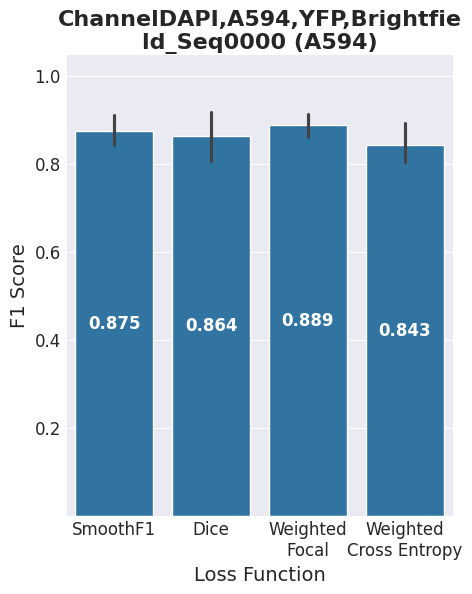

In [26]:
# Plot comparison of Piscis loss functions over each channel of each dataset.
for subdataset in piscis_f1s[dataset]:

    piscis_df = pd.DataFrame({
        'Loss Function': ['SmoothF1'] * len(piscis_f1s[dataset][subdataset]),
        'F1 Score': piscis_f1s[dataset][subdataset]
    })
    piscis_dice_df = pd.DataFrame({
        'Loss Function': ['Dice'] * len(piscis_dice_f1s[dataset][subdataset]),
        'F1 Score': piscis_dice_f1s[dataset][subdataset]
    })
    piscis_bce_df = pd.DataFrame({
        'Loss Function': ['Weighted\nCross Entropy'] * len(piscis_dice_f1s[dataset][subdataset]),
        'F1 Score': piscis_bce_f1s[dataset][subdataset]
    })
    piscis_focal_df = pd.DataFrame({
        'Loss Function': ['Weighted\nFocal'] * len(piscis_focal_f1s[dataset][subdataset]),
        'F1 Score': piscis_focal_f1s[dataset][subdataset]
    })

    parenthetical = subdataset.split('_')[-1]
    subdataset = subdataset[:-len(parenthetical) - 1]
    if parenthetical == 'subset':
        title = f'{subdataset.capitalize()} ({parenthetical.capitalize()})'
    else:
        title = f'{subdataset} ({parenthetical})'

    fig, ax = barplot(
        [piscis_df, piscis_dice_df, piscis_focal_df, piscis_bce_df],
        title=textwrap.fill(title, width=30),
        x='Loss Function',
        y='F1 Score',
        significance=False,
        ymax=1.0 + 1e-7,
        ylim=(0, 1.05),
        yticks=np.linspace(0.2, 1, 5),
        text_padding=0
    )
    fig.set_size_inches(5, 6)
    fig.savefig(panels_path / f'comparison_piscis_loss_functions_{subdataset}_{parenthetical}.pdf')

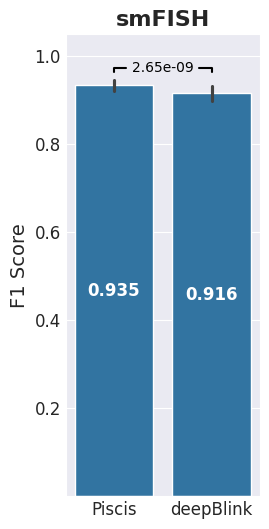

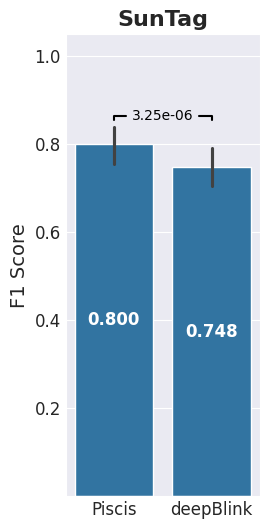

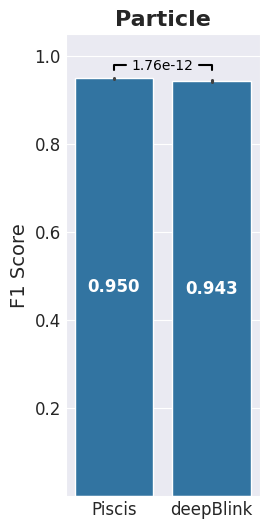

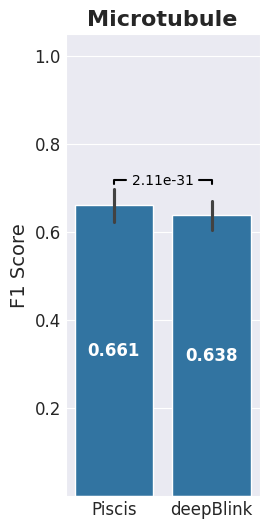

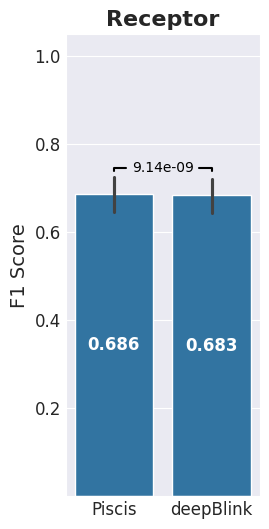

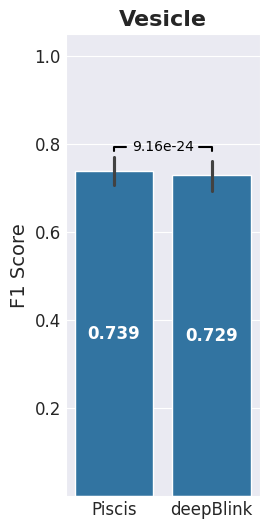

In [27]:
# Plot comparison between Piscis and deepBlink on deepBlink datasets.
for deepblink_dataset in ['smFISH', 'SunTag', 'Particle', 'Microtubule', 'Receptor', 'Vesicle']:
    k = deepblink_dataset.lower()
    v_piscis = piscis_f1s[k]
    v_deepblink = deepblink_f1s[k]
    piscis_df = pd.DataFrame({
        'Algorithm': ['Piscis'] * len(v_deepblink),
        'F1 Score': v_piscis
    })
    deepblink_df = pd.DataFrame({
        'Algorithm': ['deepBlink'] * len(v_deepblink),
        'F1 Score': v_deepblink
    })
    fig, ax = barplot(
        [piscis_df, deepblink_df],
        title=deepblink_dataset,
        x='Algorithm',
        y='F1 Score',
        ymax=1.0 + 1e-7,
        ylim=(0, 1.05),
        yticks=np.linspace(0.2, 1, 5),
        text_padding=1
    )
    ax.set_xlabel('')
    fig.set_size_inches(2.5, 6)
    fig.savefig(panels_path / f'comparison_deepblink_{k}.pdf')

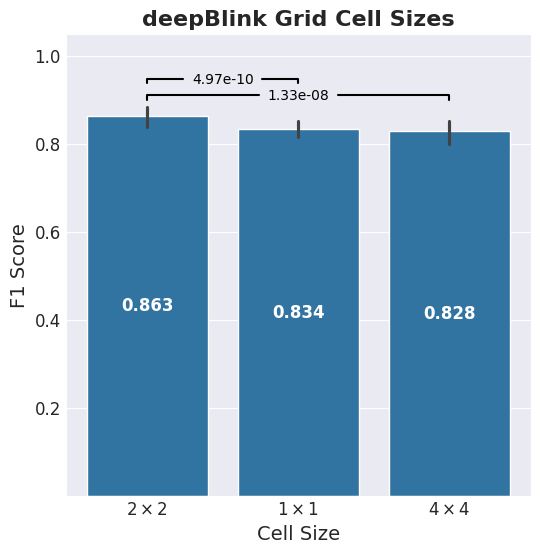

In [28]:
# Plot comparison of deepBlink cell sizes.
deepblink_cell_size_1_df = pd.DataFrame({
    'Cell Size': [r'$1\times 1$'] * len(deepblink_cell_size_1_dataset_f1s),
    'F1 Score': deepblink_cell_size_1_dataset_f1s
})
deepblink_cell_size_2_df = pd.DataFrame({
    'Cell Size': [r'$2\times 2$'] * len(deepblink_cell_size_2_dataset_f1s),
    'F1 Score': deepblink_cell_size_2_dataset_f1s
})
deepblink_cell_size_4_df = pd.DataFrame({
    'Cell Size': [r'$4\times 4$'] * len(deepblink_cell_size_4_dataset_f1s),
    'F1 Score': deepblink_cell_size_4_dataset_f1s
})
fig, ax = barplot(
    [deepblink_cell_size_2_df, deepblink_cell_size_1_df, deepblink_cell_size_4_df],
    title='deepBlink Grid Cell Sizes',
    x='Cell Size',
    y='F1 Score',
    ymax=1.0 + 1e-7,
    ylim=(0, 1.05),
    yticks=np.linspace(0.2, 1, 5),
    text_padding=0.2
)
fig.set_size_inches(6, 6)
fig.savefig(panels_path / 'comparison_deepblink_cell_sizes.pdf')

### F1 score estimation.

In [29]:
# Load F1 score estimations.
with open(benchmarks_path / 'piscis_train_smoothf1.json', 'r') as f:
    piscis_train_smoothf1 = json.load(f)
with open(benchmarks_path / 'piscis_train_dice.json', 'r') as f:
    piscis_train_dice = json.load(f)

f1s_smoothf1 = piscis_train_smoothf1['f1s']
smoothf1s = piscis_train_smoothf1['smoothf1s']
f1s_dice = piscis_train_dice['f1s']
dices = piscis_train_dice['dices']

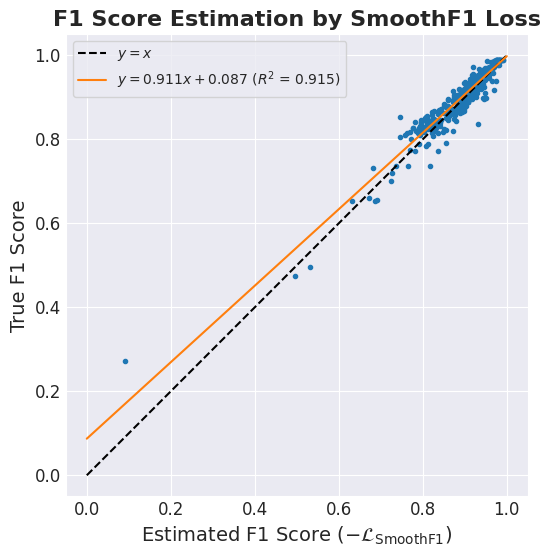

In [30]:
# Plot true F1 scores against -SmoothF1 with linear regression.
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(smoothf1s, f1s_smoothf1, '.')
x = np.array((0, 1))
slope, intercept, r_value, _, _ = stats.linregress(smoothf1s, f1s_smoothf1)
y_pred = slope * x + intercept
ax.plot((0, 1), (0, 1), label=f'$y = x$', color='black', linestyle='dashed')
ax.plot(x, y_pred, label=f'$y = {slope:.3f}x + {intercept:.3f}$ ($R^2$ = {r_value ** 2:.3f})')
ax.set_title('F1 Score Estimation by SmoothF1 Loss', fontsize=16, fontweight='bold')
ax.set_xlabel('Estimated F1 Score ($-\mathcal{L}_\mathrm{SmoothF1}$)', fontsize=14)
ax.set_ylabel('True F1 Score', fontsize=14)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.tick_params(axis='x', which='major', labelsize=12, length=0)
ax.tick_params(axis='y', which='major', labelsize=12, length=0)
ax.set_aspect('equal', adjustable='box')
plt.legend()
fig.savefig(panels_path / 'f1_score_estimation_smoothf1.pdf')

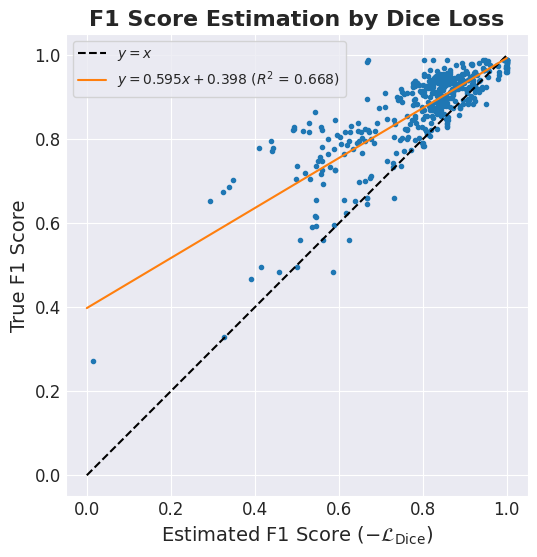

In [31]:
# Plot true F1 scores against -Dice with linear regression.
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(dices, f1s_dice, '.')
x = np.array((0, 1))
slope, intercept, r_value, _, _ = stats.linregress(dices, f1s_dice)
y_pred = slope * x + intercept
ax.plot((0, 1), (0, 1), label=f'$y = x$', color='black', linestyle='dashed')
ax.plot(x, y_pred, label=f'$y = {slope:.3f}x + {intercept:.3f}$ ($R^2$ = {r_value ** 2:.3f})')
ax.set_title('F1 Score Estimation by Dice Loss', fontsize=16, fontweight='bold')
ax.set_xlabel('Estimated F1 Score ($-\mathcal{L}_\mathrm{Dice}$)', fontsize=14)
ax.set_ylabel('True F1 Score', fontsize=14)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.tick_params(axis='x', which='major', labelsize=12, length=0)
ax.tick_params(axis='y', which='major', labelsize=12, length=0)
ax.set_aspect('equal', adjustable='box')
plt.legend()
fig.savefig(panels_path / 'f1_score_estimation_dice.pdf')

### Small offset tolerance.

In [32]:
# Load small offset tolerance tests.
with open(benchmarks_path / 'piscis_train_offset_smoothf1s.json', 'r') as f:
    piscis_train_offset_smoothf1s = json.load(f)
with open(benchmarks_path / 'piscis_train_offset_dices.json', 'r') as f:
    piscis_train_offset_dices = json.load(f)

smoothf1s = np.array(list(piscis_train_offset_smoothf1s.values()))
dices = np.array(list(piscis_train_offset_dices.values()))
sigmas = np.linspace(0, 1, 101)

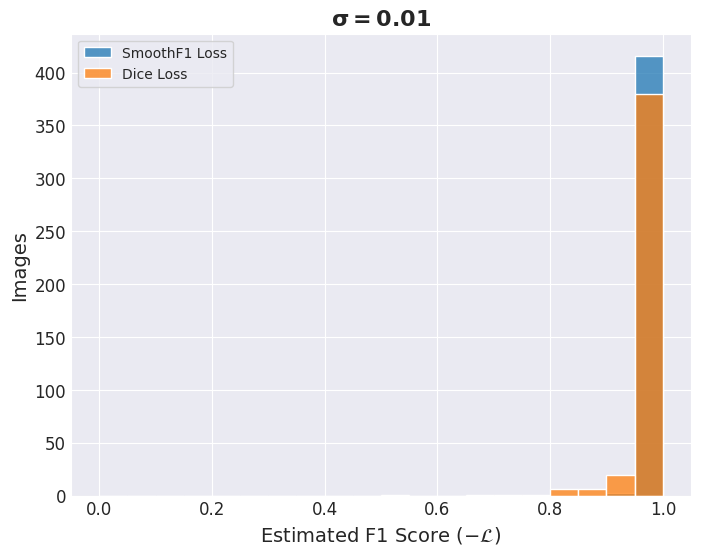

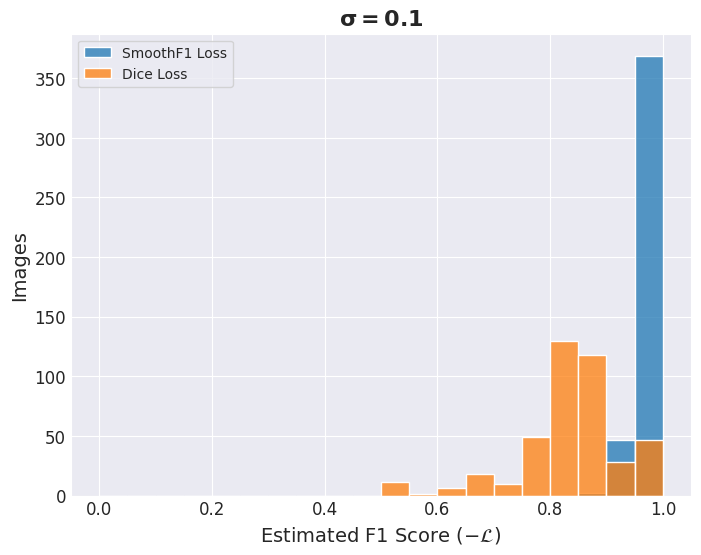

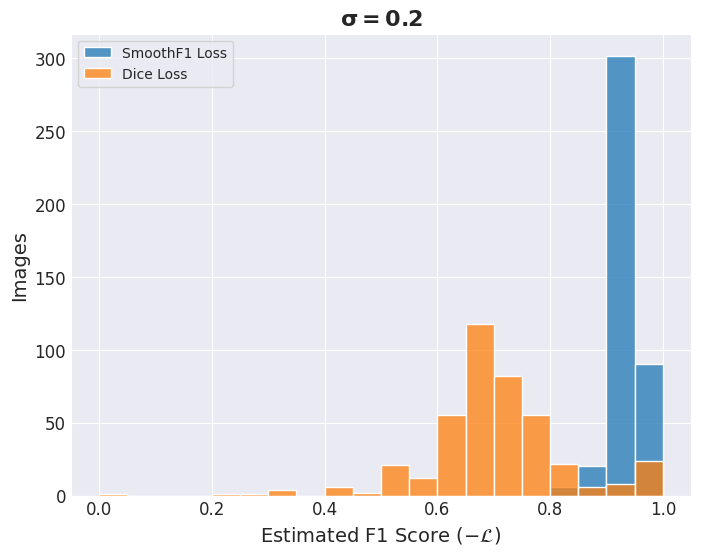

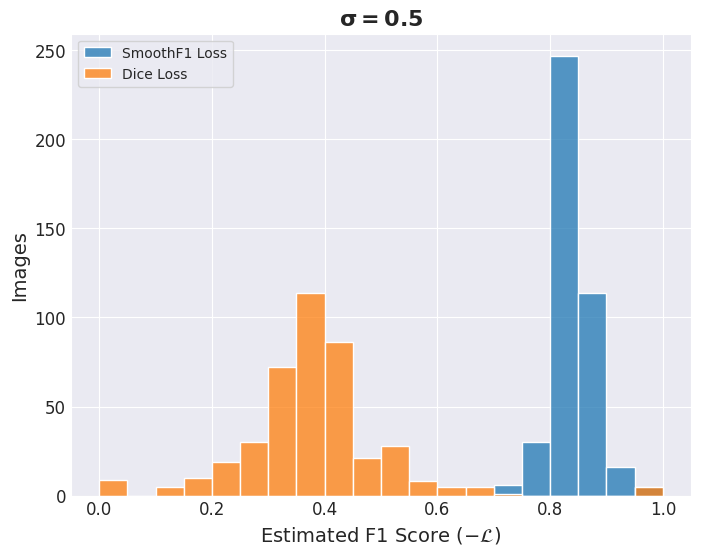

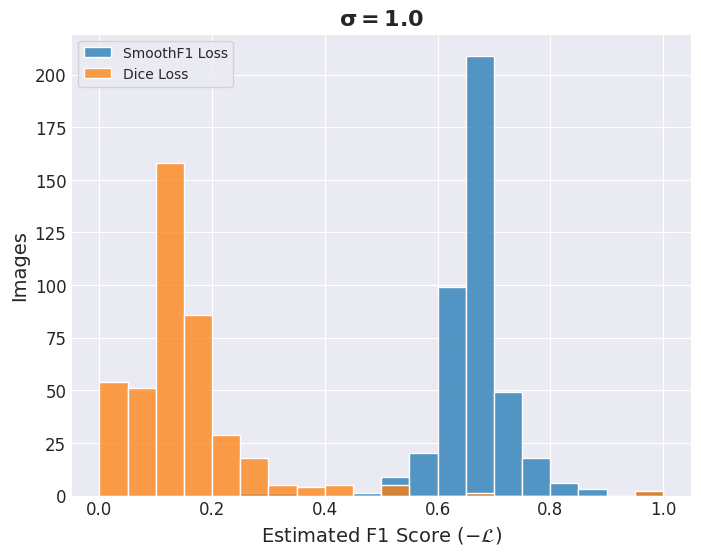

In [33]:
# Plot histograms of -SmoothF1 and -Dice for different normal distribution standard deviations.
for i in (1, 10, 20, 50, 100):

    sigma = sigmas[i]

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.histplot(smoothf1s[i], binwidth=0.05, binrange=(0, 1), label='SmoothF1 Loss')
    sns.histplot(dices[i], binwidth=0.05, binrange=(0, 1), label='Dice Loss')
    ax.set_title(f'$\\mathbf{{\\sigma={sigma}}}$', fontsize=16, fontweight='bold')
    ax.set_xlabel('Estimated F1 Score ($-\mathcal{L}$)', fontsize=14)
    ax.set_ylabel('Images', fontsize=14)
    ax.tick_params(axis='x', which='major', labelsize=12, length=0)
    ax.tick_params(axis='y', which='major', labelsize=12, length=0)
    plt.legend(loc='upper left')
    fig.savefig(panels_path / f'small_offset_tolerance_histogram_sigma_{sigma}.pdf')

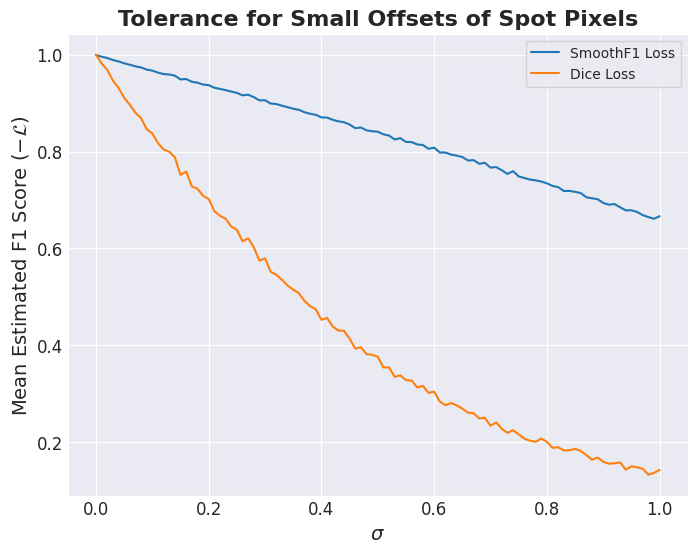

In [34]:
# Plot mean -SmoothF1 and -Dice against the normal distribution standard deviation.
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(sigmas, np.mean(smoothf1s, axis=1), label='SmoothF1 Loss')
ax.plot(sigmas, np.mean(dices, axis=1), label='Dice Loss')
ax.set_title(f'Tolerance for Small Offsets of Spot Pixels', fontsize=16, fontweight='bold')
ax.set_xlabel('$\sigma$', fontsize=14)
ax.set_ylabel('Mean Estimated F1 Score ($-\mathcal{L}$)', fontsize=14)
ax.tick_params(axis='x', which='major', labelsize=12, length=0)
ax.tick_params(axis='y', which='major', labelsize=12, length=0)
plt.legend()
fig.savefig(panels_path / f'small_offset_tolerance.pdf')

### Example image.

In [35]:
# Load the Piscis test dataset.
test_ds = load_datasets(with_dapi_path / 'A3_GFP1_A594_with_dapi.npz', adjustment=None, load_train=False, load_valid=False, load_test=True)['test']
images = test_ds['images']
coords = test_ds['coords']

In [36]:
# Choose example image.
image = images[2]
rgb_image = to_rgb(image, 25, 99.5, 25, 100)
coord = coords[2]
xlim, ylim = (88.5, 100.5), (144.5, 132.5)

# Save example image as a TIFF file.
tifffile.imwrite(tmp_path / 'image.tif', normalize(image[0]).astype(np.float32))

# Save example image as a N5 dataset.
store = zarr.N5Store(tmp_path / 'dataset.n5')
root = zarr.group(store=store)
compressor = zarr.GZip(level=-1)
root.create_dataset('example', data=normalize(image[0]), compressor=compressor, overwrite=True)

/usr/local/lib/python3.10/dist-packages/zarr/n5.py:77: FutureWarning: The N5Store is deprecated and will be removed in a Zarr-Python version 3, see https://github.com/zarr-developers/zarr-python/issues/1274 for more information.
  super().__init__(*args, **kwargs)
<ipython-input-36-c23e6e59781a>:11: FutureWarning: The N5Store is deprecated and will be removed in a Zarr-Python version 3, see https://github.com/zarr-developers/zarr-python/issues/1274 and https://github.com/zarr-developers/n5py for more information.
  store = zarr.N5Store(tmp_path / 'dataset.n5')


<zarr.core.Array '/example' (256, 256) float64>

In [37]:
# Extract the best parameters for TrackMate on example image.
radii = np.linspace(1.0, 3.0, 5)
thresholds = np.linspace(0.02, 0.4, 20)
trackmate_f1s_array = np.array([list(a.values()) for a in trackmate_f1s['A3_GFP1_A594']['2'].values()])
trackmate_best_index = np.argmax(trackmate_f1s_array)
trackmate_best_index = np.unravel_index(trackmate_best_index, trackmate_f1s_array.shape)
trackmate_best_radius = radii[trackmate_best_index[0]]
trackmate_best_threshold = thresholds[trackmate_best_index[1]]

In [38]:
# Find the best parameters for RS-FISH on example image.
sigmas = np.linspace(1.0, 3.0, 5)
thresholds = np.linspace(0.002, 0.04, 20)
rs_fish_f1s_array = np.array([list(a.values()) for a in rs_fish_f1s['A3_GFP1_A594']['2'].values()])
rs_fish_best_index = np.argmax(rs_fish_f1s_array)
rs_fish_best_index = np.unravel_index(rs_fish_best_index, rs_fish_f1s_array.shape)
rs_fish_best_sigma = sigmas[rs_fish_best_index[0]]
rs_fish_best_threshold = thresholds[rs_fish_best_index[1]]

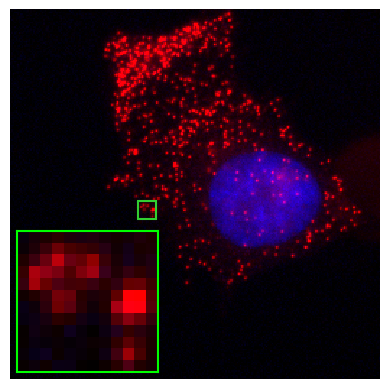

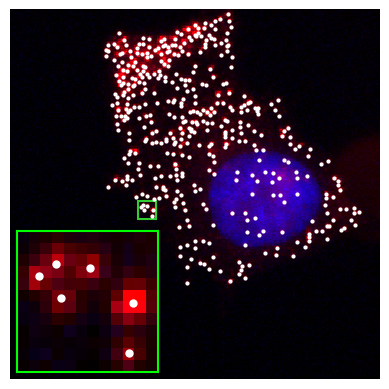

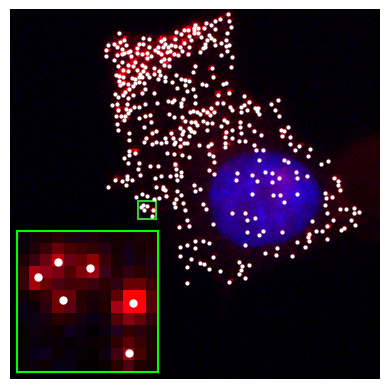

1/1 [==============================] - 1s 535ms/step


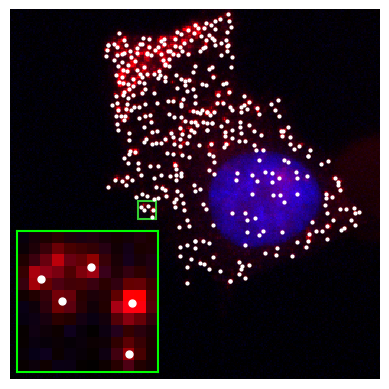

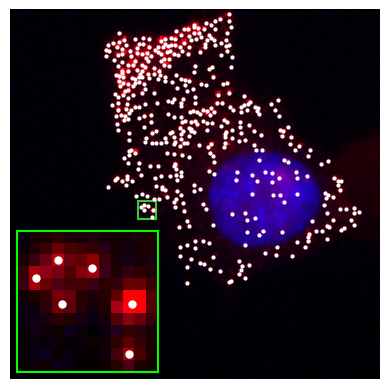

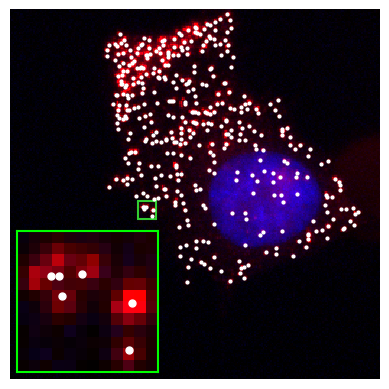

In [39]:
# Show example image.
fig, ax = plt.subplots()
ax.imshow(rgb_image, interpolation='none')
strip_axes(ax)
axins = ax.inset_axes([0.02, 0.02, 0.38, 0.38])
axins.imshow(rgb_image, interpolation='none')
axins.set_xlim(xlim)
axins.set_ylim(ylim)
strip_axes(axins, spine=False)
for spine in axins.spines.values():
    spine.set_edgecolor('lime')
    spine.set_linewidth(1.5)
_, p1, p2 = mark_inset(ax, axins, loc1=1, loc2=2, edgecolor='limegreen', linewidth=1.5)
p1.set_visible(False)
p2.set_visible(False)
fig.savefig(panels_path / 'example.pdf', dpi=300)
display(fig)

# Show example image with ground truth annotations.
scatter = ax.plot(coord[:, 1], coord[:, 0], '.', c='white', markersize=4)
scatter_zoomed = axins.plot(coord[:, 1], coord[:, 0], '.', c='white', markersize=10)
fig.savefig(panels_path / 'example_ground_truth.pdf')
display(fig)
for point in scatter + scatter_zoomed:
    point.remove()

# Create a dictionary for F1 scores.
f1s = {}

# Show example image with Piscis predictions.
coord_pred_piscis, y = piscis_model.predict(image[0], intermediates=True)
f1 = compute_metrics(coord_pred_piscis, coord, evaluation_metrics='f1', distance_thresholds=np.linspace(0, 3, 50))['f1']
f1s['f1'] = f1
scatter = ax.plot(coord_pred_piscis[:, 1], coord_pred_piscis[:, 0], '.', c='white', markersize=4)
scatter_zoomed = axins.plot(coord_pred_piscis[:, 1], coord_pred_piscis[:, 0], '.', c='white', markersize=10)
fig.savefig(panels_path / 'example_piscis.pdf')
display(fig)
for point in scatter + scatter_zoomed:
    point.remove()

# Show example image with deepBlink predictions.
coord_pred = predict(image[0], deepblink_model)
f1 = compute_metrics(coord_pred, coord, evaluation_metrics='f1', distance_thresholds=np.linspace(0, 3, 50))['f1']
f1s['deepblink'] = f1
scatter = ax.plot(coord_pred[:, 1], coord_pred[:, 0], '.', c='white', markersize=4)
scatter_zoomed = axins.plot(coord_pred[:, 1], coord_pred[:, 0], '.', c='white', markersize=10)
fig.savefig(panels_path / 'example_deepblink.pdf')
display(fig)
for point in scatter + scatter_zoomed:
    point.remove()

# Show example image with TrackMate predictions using best parameters.
args = {'radius': float(trackmate_best_radius), 'threshold': float(trackmate_best_threshold)}
result = ij.py.run_script('groovy', script, args).getOutput('result')
coord_pred = np.array([[float(str(string)) for string in list(row)[1::-1]] for row in result])
f1 = compute_metrics(coord_pred, coord, evaluation_metrics='f1', distance_thresholds=np.linspace(0, 3, 50))['f1']
f1s['trackmate'] = f1
scatter = ax.plot(coord_pred[:, 1], coord_pred[:, 0], '.', c='white', markersize=4)
scatter_zoomed = axins.plot(coord_pred[:, 1], coord_pred[:, 0], '.', c='white', markersize=10)
fig.savefig(panels_path / 'example_trackmate.pdf')
display(fig)
for point in scatter + scatter_zoomed:
    point.remove()

# Show example image with RS-FISH predictions using best parameters.
command = base_command + ['--dataset=example', f'--sigma={rs_fish_best_sigma}', f'--threshold={rs_fish_best_threshold}']
with open(tmp_path / 'output_log.txt', 'w') as output_log:
    result = subprocess.run(command, stdout=output_log, stderr=output_log)
csv = pd.read_csv(tmp_path / 'output.csv')
coord_pred = np.stack((csv['y'], csv['x']), axis=-1)
f1 = compute_metrics(coord_pred, coord, evaluation_metrics='f1', distance_thresholds=np.linspace(0, 3, 50))['f1']
f1s['rs_fish'] = f1
scatter = ax.plot(coord_pred[:, 1], coord_pred[:, 0], '.', c='white', markersize=4)
scatter_zoomed = axins.plot(coord_pred[:, 1], coord_pred[:, 0], '.', c='white', markersize=10)
fig.savefig(panels_path / 'example_rs_fish.pdf')

# Save F1 scores.
with open(panels_path / 'example_f1s.json', 'w') as f:
    json.dump(f1s, f)

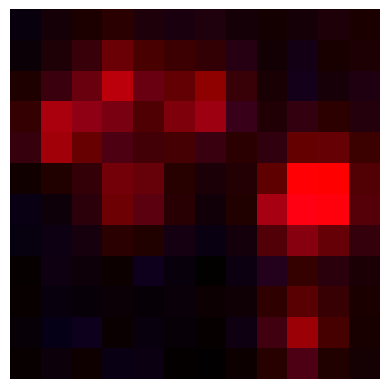

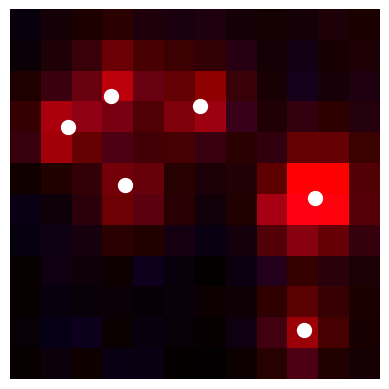

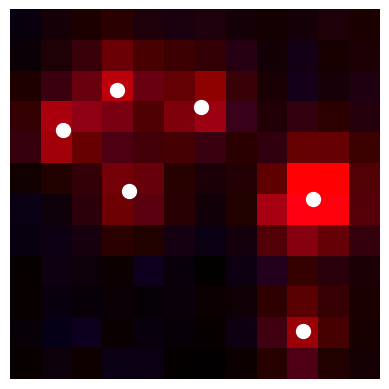

In [40]:
# Show crop of example image.
fig, ax = plt.subplots()
ax.imshow(rgb_image, interpolation='none')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
strip_axes(ax)
fig.savefig(panels_path / 'example_crop.pdf')
display(fig)

# Show crop of example image with ground truth annotations.
scatter = ax.plot(coord[:, 1], coord[:, 0], '.', c='white', markersize=20)
fig.savefig(panels_path / 'example_crop_ground_truth.pdf')
display(fig)
for point in scatter:
    point.remove()

# Show crop of example image with Piscis predictions.
scatter = ax.plot(coord_pred_piscis[:, 1], coord_pred_piscis[:, 0], '.', c='white', markersize=20)
fig.savefig(panels_path / 'example_crop_piscis.pdf')

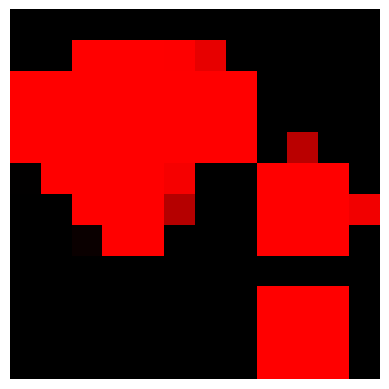

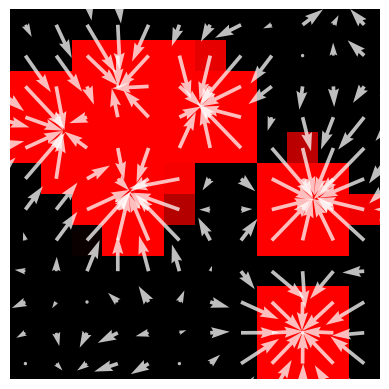

In [41]:
# Show crop of example image with predicted labels.
fig, ax = plt.subplots()
ax.imshow(y[2], cmap=black_red, interpolation='none')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
strip_axes(ax)
fig.savefig(panels_path / 'example_crop_labels.pdf')
display(fig)

# Show crop of example image with predicted displacements.
mgrid = np.mgrid[:y.shape[-2], :y.shape[-1]]
ax.quiver(mgrid[1], mgrid[0], y[1], y[0], angles='xy', scale_units='xy', scale=1, width=0.01, alpha=0.75, color='white')
fig.savefig(panels_path / 'example_crop_displacements.pdf')

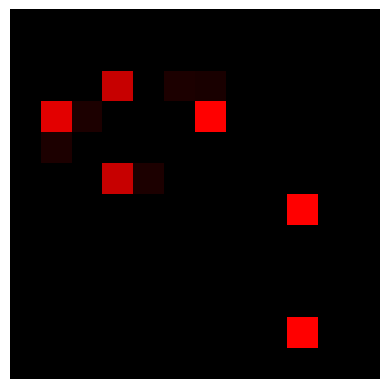

In [42]:
# Show crop of example image with predicted pooled labels.
fig, ax = plt.subplots()
ax.imshow(y[3], cmap=black_red, interpolation='none')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
strip_axes(ax)
fig.savefig(panels_path / 'example_crop_pooled_labels.pdf')

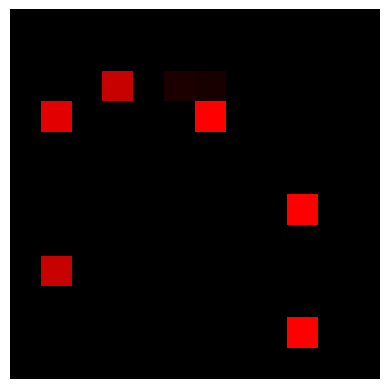

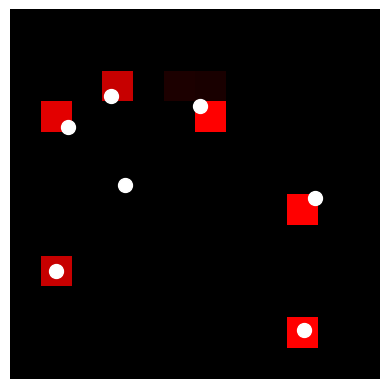

In [43]:
# Create hypothetical pooled labels.
hypothetical_pooled_labels = y[3].copy()
hypothetical_pooled_labels[136, 91:95] = 0
hypothetical_pooled_labels[137:140, 90:95] = 0
hypothetical_pooled_labels[141, 90] = 7

# Show crop of example image with hypothetical pooled labels.
fig, ax = plt.subplots()
ax.imshow(hypothetical_pooled_labels, cmap=black_red, interpolation='none')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
strip_axes(ax)
fig.savefig(panels_path / 'example_crop_hypothetical_pooled_labels.pdf')
display(fig)

# Show crop of example image with annotated hypothetical pooled labels.
ax.plot(coord[:, 1], coord[:, 0], '.', c='white', markersize=20)
ax.plot(90, 141, '.', c='white', markersize=20)
fig.savefig(panels_path / 'example_crop_hypothetical_pooled_labels_annotated.pdf')

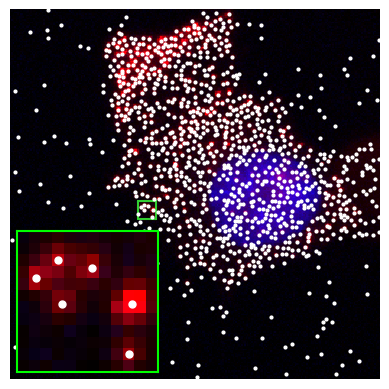

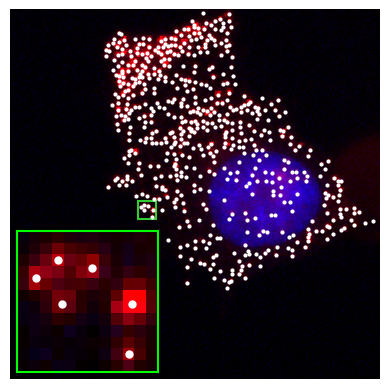

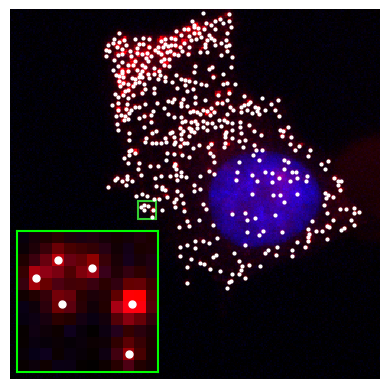

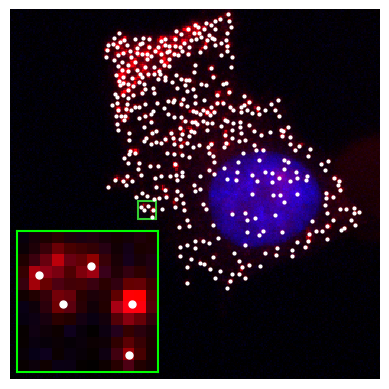

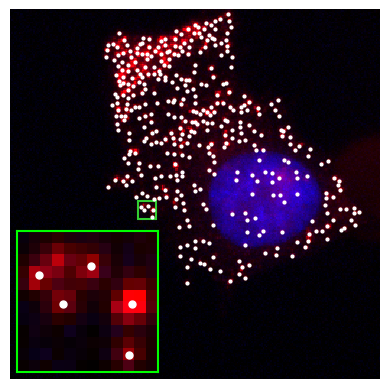

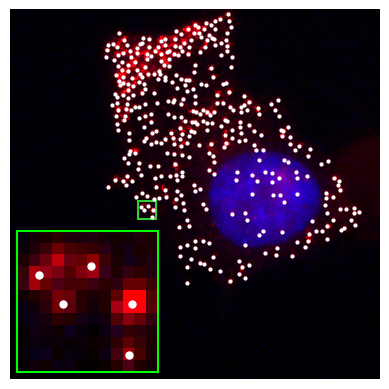

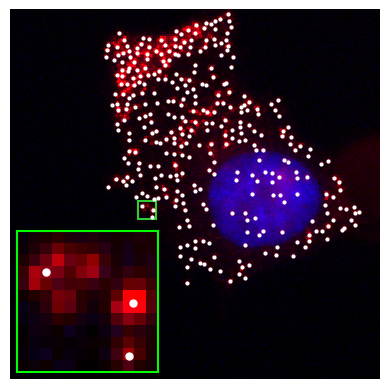

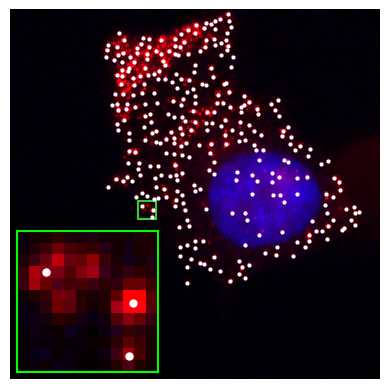

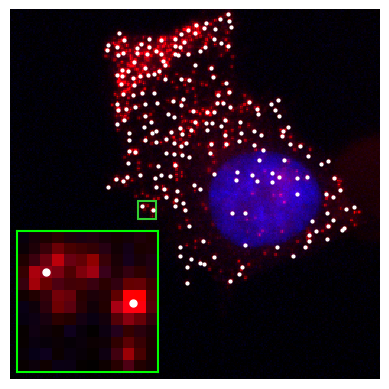

In [44]:
# Define parameter grid.
radii = [1.0, 1.5, 2.0]
thresholds = [0.03, 0.06, 0.09]

fig, ax = plt.subplots()
ax.imshow(rgb_image, interpolation='none')
strip_axes(ax)
axins = ax.inset_axes([0.02, 0.02, 0.38, 0.38])
axins.imshow(rgb_image, interpolation='none')
axins.set_xlim(xlim)
axins.set_ylim(ylim)
strip_axes(axins, spine=False)
for spine in axins.spines.values():
    spine.set_edgecolor('lime')
    spine.set_linewidth(1.5)
_, p1, p2 = mark_inset(ax, axins, loc1=1, loc2=2, edgecolor='limegreen', linewidth=1.5)
p1.set_visible(False)
p2.set_visible(False)

# Create a list for F1 scores.
f1s = []

# Show example image with TrackMate predictions using parameters in the parameter grid.
for radius in radii:
    for threshold in thresholds:
        args = {'radius': float(radius), 'threshold': float(threshold)}
        result = ij.py.run_script('groovy', script, args).getOutput('result')
        coord_pred = np.array([[float(str(string)) for string in list(row)[1::-1]] for row in result])
        f1 = compute_metrics(coord_pred, coord, evaluation_metrics='f1', distance_thresholds=np.linspace(0, 3, 50))['f1']
        f1s.append({'radius': radius, 'threshold': threshold, 'f1': f1})
        scatter = ax.plot(coord_pred[:, 1], coord_pred[:, 0], '.', c='white', markersize=4)
        scatter_zoomed = axins.plot(coord_pred[:, 1], coord_pred[:, 0], '.', c='white', markersize=10)
        fig.savefig(panels_path / f'example_trackmate_radius_{radius}_threshold_{threshold}.pdf')
        display(fig)
        for point in scatter + scatter_zoomed:
            point.remove()

plt.close()

# Save F1 scores.
with open(panels_path / 'example_trackmate_parameter_grid_f1s.json', 'w') as f:
    json.dump(f1s, f)

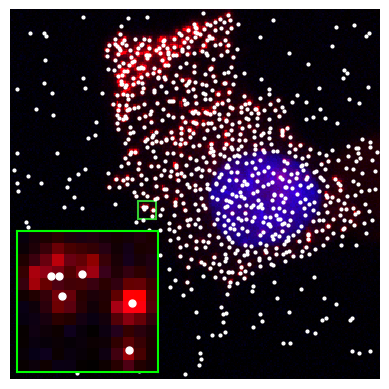

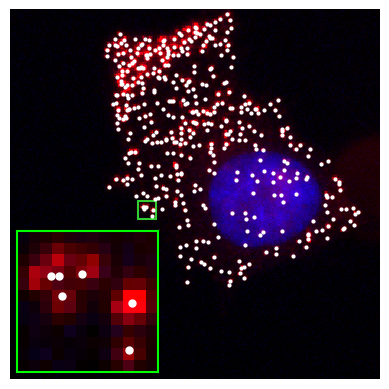

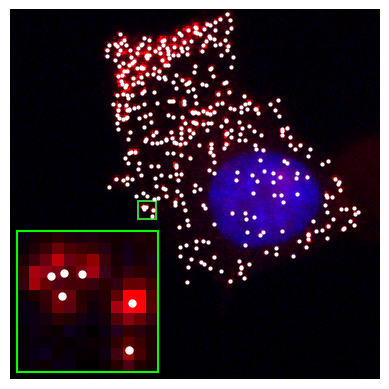

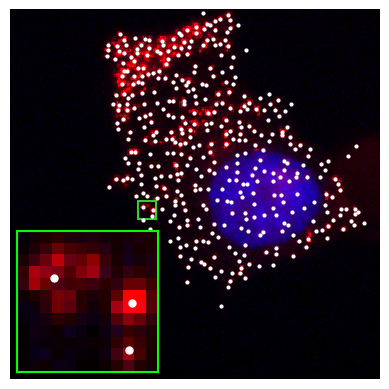

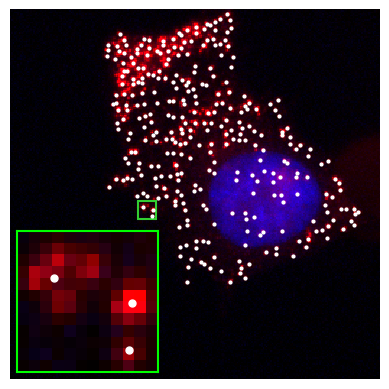

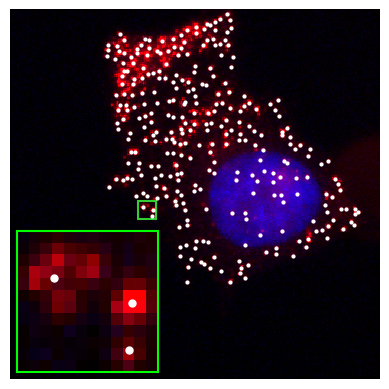

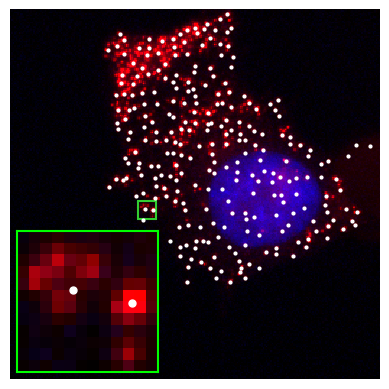

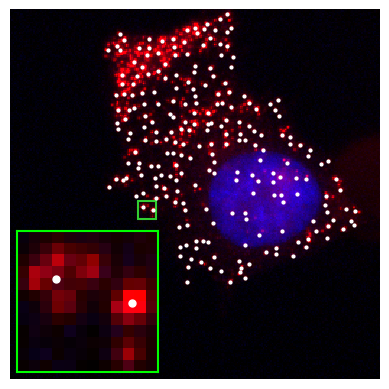

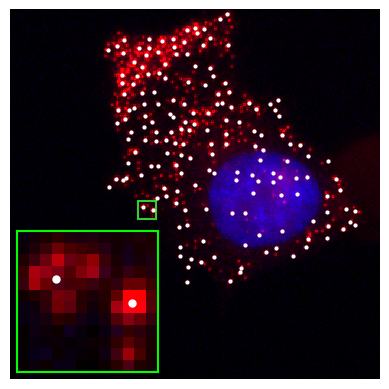

In [45]:
# Define parameter grid.
sigmas = [1.0, 1.5, 2.0]
thresholds = [0.001, 0.005, 0.009]

fig, ax = plt.subplots()
ax.imshow(rgb_image, interpolation='none')
strip_axes(ax)
axins = ax.inset_axes([0.02, 0.02, 0.38, 0.38])
axins.imshow(rgb_image, interpolation='none')
axins.set_xlim(xlim)
axins.set_ylim(ylim)
strip_axes(axins, spine=False)
for spine in axins.spines.values():
    spine.set_edgecolor('lime')
    spine.set_linewidth(1.5)
_, p1, p2 = mark_inset(ax, axins, loc1=1, loc2=2, edgecolor='limegreen', linewidth=1.5)
p1.set_visible(False)
p2.set_visible(False)

# Create a list for F1 scores.
f1s = []

# Show example image with RS-FISH predictions using parameters in the parameter grid.
for sigma in sigmas:
    for threshold in thresholds:
        command = base_command + ['--dataset=example', f'--sigma={sigma}', f'--threshold={threshold}']
        with open(tmp_path / 'output_log.txt', 'w') as output_log:
            result = subprocess.run(command, stdout=output_log, stderr=output_log)
        csv = pd.read_csv(tmp_path / 'output.csv')
        coord_pred = np.stack((csv['y'], csv['x']), axis=-1)
        f1 = compute_metrics(coord_pred, coord, evaluation_metrics='f1', distance_thresholds=np.linspace(0, 3, 50))['f1']
        f1s.append({'sigma': sigma, 'threshold': threshold, 'f1': f1})
        scatter = ax.plot(coord_pred[:, 1], coord_pred[:, 0], '.', c='white', markersize=4)
        scatter_zoomed = axins.plot(coord_pred[:, 1], coord_pred[:, 0], '.', c='white', markersize=10)
        fig.savefig(panels_path / f'example_rs_fish_sigma_{sigma}_threshold_{threshold}.pdf')
        display(fig)
        for point in scatter + scatter_zoomed:
            point.remove()

plt.close()

# Save F1 scores.
with open(panels_path / 'example_rs_fish_parameter_grid_f1s.json', 'w') as f:
    json.dump(f1s, f)

### Autofluorescence Image.

In [46]:
# # Save subsetted image.
# auto_image_path = Path('autofluorescence/20220214_162350_947__ChannelDAPI,YFP,YFPa,CY3,CY3a,A594,A594a,CY5,CY5a,Brightfield_Seq0001.nd2')
# auto_image = nd2.imread(auto_image_path, dask=True, xarray=True)
# auto_image.coords['channel_names'] = auto_image.coords['C']
# for axis, size in auto_image.sizes.items():
#     auto_image.coords[axis] = np.arange(size)
# auto_image.attrs['axes_calibration'] = auto_image.attrs.pop('metadata')['metadata'].channels[0].volume.axesCalibration
# auto_image = auto_image[93, 2, [0, 3], 256:768, :512]
# auto_image.to_netcdf(f'autofluorescence/{auto_image_path.stem}.nc', format='NETCDF4')
# tifffile.imwrite(f'autofluorescence/{auto_image_path.stem}.tif', auto_image, metadata={'axes': 'CYX'})

In [47]:
# Load autofluorescence image.
auto_image = xr.load_dataarray('autofluorescence/20220214_162350_947__ChannelDAPI,YFP,YFPa,CY3,CY3a,A594,A594a,CY5,CY5a,Brightfield_Seq0001.nc')
auto_image_microns_per_pixel = auto_image.axes_calibration[0]
auto_image = np.array([auto_image[1], auto_image[0]])
auto_rgb_image = to_rgb(auto_image, 25, 95, 25, 99)
auto_xlim, auto_ylim = (255.5, 383.5), (342.5, 214.5)

# Load ground truth annotations.
with open('autofluorescence/20220214_162350_947__ChannelDAPI,YFP,YFPa,CY3,CY3a,A594,A594a,CY5,CY5a,Brightfield_Seq0001.json', 'r') as f:
    annotations = json.load(f)['annotations']
auto_coord = np.array([[annotation['coordinates'][0]['y'] - 0.5, annotation['coordinates'][0]['x'] - 0.5] for annotation in annotations])

# Process coordinates by snapping, fitting, and removal of duplicates.
auto_coord = snap_coords(auto_coord, auto_image[0])
auto_coord = fit_coords(auto_coord, auto_image[0])
auto_coord = remove_duplicate_coords(auto_coord)

# Save autofluorescence image as a TIFF file.
tifffile.imwrite(tmp_path / 'image.tif', normalize(auto_image[0]).astype(np.float32))

# Save autofluorescence image as a N5 dataset.
store = zarr.N5Store(tmp_path / 'dataset.n5')
root = zarr.group(store=store)
compressor = zarr.GZip(level=-1)
root.create_dataset('autofluorescence', data=normalize(auto_image[0]), compressor=compressor, overwrite=True)

/usr/local/lib/python3.10/dist-packages/zarr/n5.py:77: FutureWarning: The N5Store is deprecated and will be removed in a Zarr-Python version 3, see https://github.com/zarr-developers/zarr-python/issues/1274 for more information.
  super().__init__(*args, **kwargs)
<ipython-input-47-5fb049d6280a>:22: FutureWarning: The N5Store is deprecated and will be removed in a Zarr-Python version 3, see https://github.com/zarr-developers/zarr-python/issues/1274 and https://github.com/zarr-developers/n5py for more information.
  store = zarr.N5Store(tmp_path / 'dataset.n5')


<zarr.core.Array '/autofluorescence' (512, 512) float64>

In [48]:
# Get the microns per pixel values for images in the Piscis training dataset.
train_microns_per_pixel = {}
for path1 in images_path.glob('*.nc'):
    microns_per_pixel = xr.load_dataarray(path1).axes_calibration[0]
    train_size = sum(len(load_datasets(path2, adjustment=None, load_train=True, load_valid=False, load_test=False)['train']['images']) for path2 in dataset_path.glob(f'{path1.stem}*'))
    train_microns_per_pixel[path1.stem] = {'value': microns_per_pixel, 'n': train_size}
print(json.dumps(train_microns_per_pixel, indent=4))

{
    "ChannelDAPI,A594,YFP,Brightfield_Seq0000": {
        "value": 0.215531968923804,
        "n": 22
    },
    "20191221_183732_211__ChannelDAPI,CY3,A594,CY5,Brightfield_Seq0000_crop1to1407_14Jan2019": {
        "value": 0.21403879653681,
        "n": 11
    },
    "A3_GFP1": {
        "value": 0.216666666666666,
        "n": 95
    },
    "20220612_101953_317__Well2_ChannelDAPI,CY3,A594,Brightfield_Seq0001": {
        "value": 0.21362253412392,
        "n": 22
    },
    "Well2_ChannelDAPI_DMin,CY3,A594,CY5,CY7_Seq0000": {
        "value": 0.21362253412392,
        "n": 15
    },
    "untreated014": {
        "value": 0.21362253412392,
        "n": 85
    }
}


In [49]:
# Compute the mean micros per pixel value for the Piscis training dataset.
mean_train_microns_per_pixel = sum(v['value'] * v['n'] for v in train_microns_per_pixel.values()) / sum(v['n'] for v in train_microns_per_pixel.values())
mean_train_microns_per_pixel

0.21496565029872045

In [50]:
# Compute the scale factor necessary for the autofluorescence image to have the same microns per pixel value as the Piscis training dataset.
scale = auto_image_microns_per_pixel / mean_train_microns_per_pixel
scale

1.5108266397616839

In [51]:
# Find the best parameters for TrackMate on autofluorescence image.

# Cached parameters.
trackmate_best_radius = 1.5
trackmate_best_threshold = 0.08

# Change this to recompute best parameters.
recompute_best_parameters = False

if recompute_best_parameters:

    # Define grid search.
    radii = np.linspace(1.0, 3.0, 5)
    thresholds = np.linspace(0.02, 0.4, 20)

    f1s = {}
    for i, radius in enumerate(radii):
        f1s.setdefault(i, {})
        for j, threshold in enumerate(thresholds):
            args = {'radius': float(radius), 'threshold': float(threshold)}
            result = ij.py.run_script('groovy', script, args).getOutput('result')
            trackmate_auto_coord_pred = np.array([[float(str(string)) for string in list(row)[1::-1]] for row in result])
            if (trackmate_auto_coord_pred.size > 0) and (auto_coord.size > 0):
                f1 = compute_metrics(trackmate_auto_coord_pred, auto_coord, evaluation_metrics='f1', distance_thresholds=np.linspace(0, 3, 50))['f1']
            else:
                f1 = 0
            f1s[i][j] = f1

    trackmate_f1s_array = np.array([list(a.values()) for a in f1s.values()])
    trackmate_best_index = np.argmax(trackmate_f1s_array)
    trackmate_best_index = np.unravel_index(trackmate_best_index, trackmate_f1s_array.shape)
    trackmate_best_radius = radii[trackmate_best_index[0]]
    trackmate_best_threshold = thresholds[trackmate_best_index[1]]

In [52]:
# Find the best parameters for RS-FISH on autofluorescence image.

# Cached parameters.
rs_fish_best_sigma = 1.0
rs_fish_best_threshold = 0.01

# Change this to recompute best parameters.
recompute_best_parameters = False

if recompute_best_parameters:

    # Define grid search.
    sigmas = np.linspace(1.0, 3.0, 5)
    thresholds = np.linspace(0.002, 0.04, 20)

    f1s = {}
    for i, sigma in enumerate(sigmas):
        f1s.setdefault(i, {})
        for j, threshold in enumerate(thresholds):
            command = base_command + ['--dataset=autofluorescence', f'--sigma={sigma}', f'--threshold={threshold}']
            with open(tmp_path / 'output_log.txt', 'w') as output_log:
                result = subprocess.run(command, stdout=output_log, stderr=output_log)
            try:
                csv = pd.read_csv(tmp_path / 'output.csv')
                rs_fish_auto_coord_pred = np.stack((csv['y'], csv['x']), axis=-1)
                if (rs_fish_auto_coord_pred.size > 0) and (auto_coord.size > 0):
                    f1 = compute_metrics(rs_fish_auto_coord_pred, auto_coord, evaluation_metrics='f1', distance_thresholds=np.linspace(0, 3, 50))['f1']
                else:
                    f1 = 0
            except pd.errors.EmptyDataError:
                f1 = 0
            f1s[i][j] = f1

    rs_fish_f1s_array = np.array([list(a.values()) for a in f1s.values()])
    rs_fish_best_index = np.argmax(rs_fish_f1s_array)
    rs_fish_best_index = np.unravel_index(rs_fish_best_index, rs_fish_f1s_array.shape)
    rs_fish_best_sigma = sigmas[rs_fish_best_index[0]]
    rs_fish_best_threshold = thresholds[rs_fish_best_index[1]]

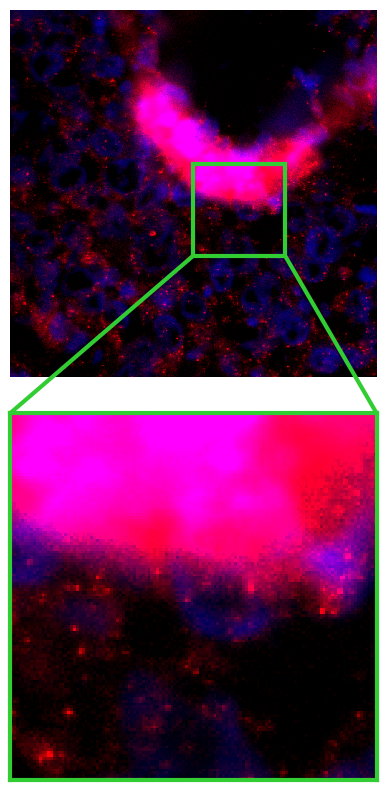

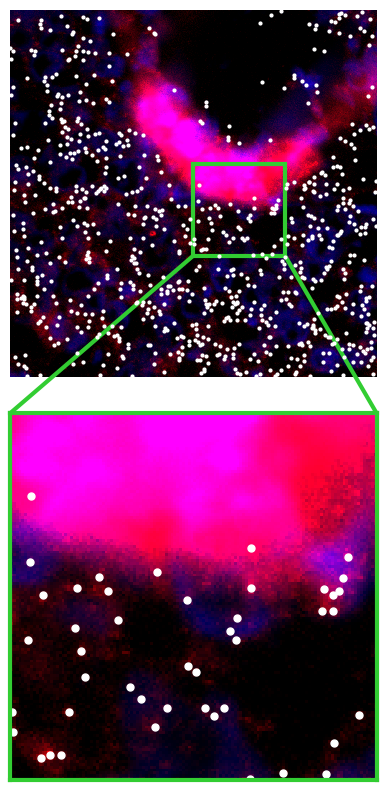

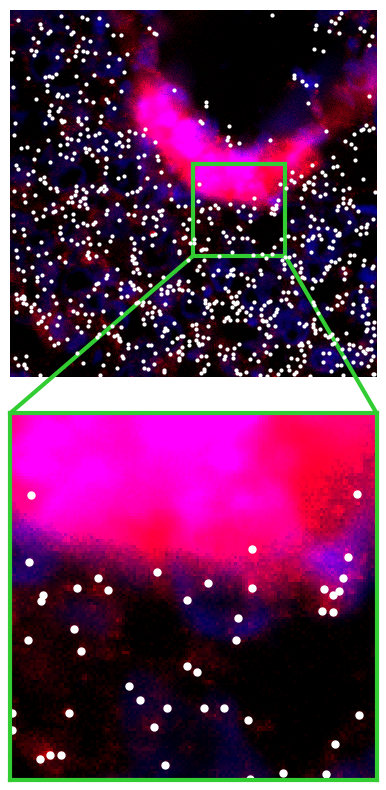

1/1 [==============================] - 6s 6s/step


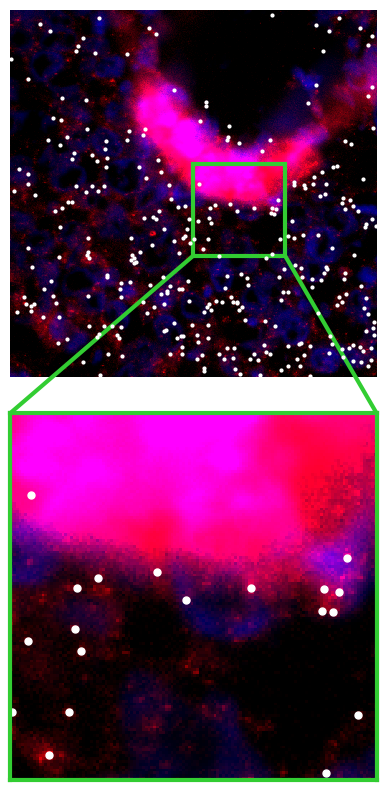

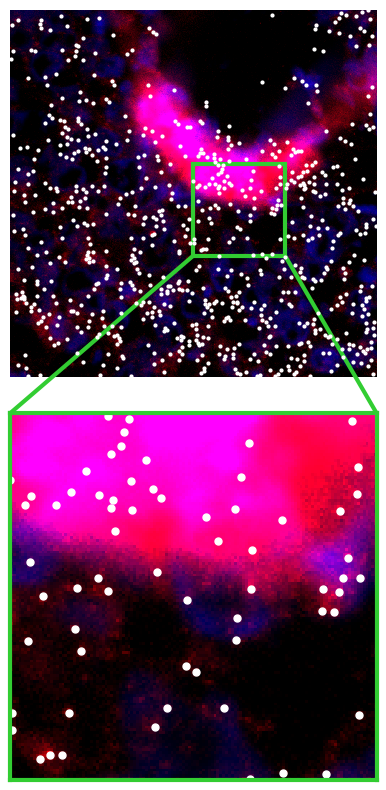

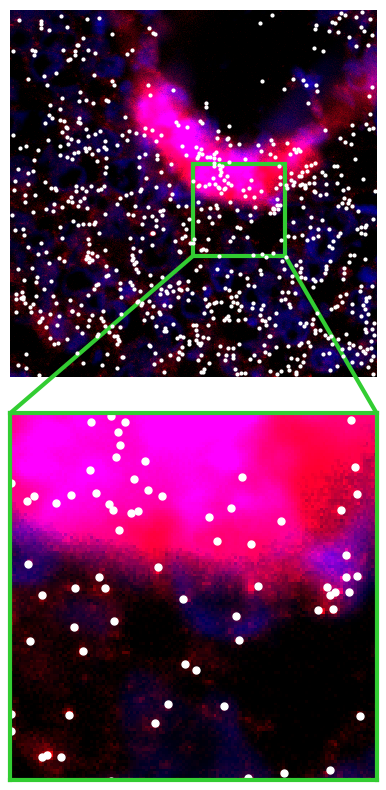

In [53]:
# Show autofluorescence image.
fig, (ax, ax_zoomed) = plt.subplots(2, 1, figsize=(4.8, 10), gridspec_kw={'hspace': 0.1})
ax.imshow(auto_rgb_image, interpolation='none')
strip_axes(ax)
ax_zoomed.imshow(auto_rgb_image, interpolation='none')
ax_zoomed.set_xlim(auto_xlim)
ax_zoomed.set_ylim(auto_ylim)
strip_axes(ax_zoomed, spine=False)
for spine in ax_zoomed.spines.values():
    spine.set_edgecolor('limegreen')
    spine.set_linewidth(3)
rect = Rectangle((auto_xlim[0], auto_ylim[0]), auto_xlim[1] - auto_xlim[0], auto_ylim[1] - auto_ylim[0], edgecolor='limegreen', linewidth=3, fill=False)
ax.add_patch(rect)
con1 = ConnectionPatch(xyA=(auto_xlim[0], auto_ylim[0]), xyB=(auto_xlim[0], auto_ylim[1]), coordsA=ax.transData, coordsB=ax_zoomed.transData,
                       axesA=ax, axesB=ax_zoomed, color='limegreen', linewidth=3, mutation_scale=5)
ax.add_artist(con1)
con2 = ConnectionPatch(xyA=(auto_xlim[1], auto_ylim[0]), xyB=(auto_xlim[1], auto_ylim[1]), coordsA=ax.transData, coordsB=ax_zoomed.transData,
                       axesA=ax, axesB=ax_zoomed, color='limegreen', linewidth=3, mutation_scale=5)
ax.add_artist(con2)
fig.savefig(panels_path / 'autofluorescence.pdf')
display(fig)

# Show autofluorescence image with ground truth annotations.
scatter = ax.plot(auto_coord[:, 1], auto_coord[:, 0], '.', c='white', markersize=4)
scatter_zoomed = ax_zoomed.plot(auto_coord[:, 1], auto_coord[:, 0], '.', c='white', markersize=10)
fig.savefig(panels_path / 'autofluorescence_ground_truth.pdf')
display(fig)
for point in scatter + scatter_zoomed:
    point.remove()

# Create a dictionary for F1 scores.
f1s = {}

# Show autofluorescence image with Piscis predictions.
auto_coord_pred = piscis_model.predict(auto_image[0], scale=scale)
f1 = compute_metrics(auto_coord_pred, auto_coord, evaluation_metrics='f1', distance_thresholds=np.linspace(0, 3, 50))['f1']
f1s['f1'] = f1
scatter = ax.plot(auto_coord_pred[:, 1], auto_coord_pred[:, 0], '.', c='white', markersize=4)
scatter_zoomed = ax_zoomed.plot(auto_coord_pred[:, 1], auto_coord_pred[:, 0], '.', c='white', markersize=10)
fig.savefig(panels_path / 'autofluorescence_piscis.pdf')
display(fig)
for point in scatter + scatter_zoomed:
    point.remove()

# Show autofluorescence image with deepBlink predictions.
auto_image_size = auto_image.shape[-2:]
scaled_auto_image_size = (round(auto_image_size[0] * scale), round(auto_image_size[1] * scale))
auto_coord_pred = predict(resize(auto_image[0], scaled_auto_image_size), deepblink_model)
auto_coord_pred[:, -2:] = auto_coord_pred[:, -2:] * (np.array([auto_image_size]) - 1) / (np.array(scaled_auto_image_size) - 1)
f1 = compute_metrics(auto_coord_pred, auto_coord, evaluation_metrics='f1', distance_thresholds=np.linspace(0, 3, 50))['f1']
f1s['deepblink'] = f1
scatter = ax.plot(auto_coord_pred[:, 1], auto_coord_pred[:, 0], '.', c='white', markersize=4)
scatter_zoomed = ax_zoomed.plot(auto_coord_pred[:, 1], auto_coord_pred[:, 0], '.', c='white', markersize=10)
fig.savefig(panels_path / 'autofluorescence_deepblink.pdf')
display(fig)
for point in scatter + scatter_zoomed:
    point.remove()

# Show autofluorescence image with TrackMate predictions using best parameters.
args = {'radius': float(trackmate_best_radius), 'threshold': float(trackmate_best_threshold)}
result = ij.py.run_script('groovy', script, args).getOutput('result')
auto_coord_pred = np.array([[float(str(string)) for string in list(row)[1::-1]] for row in result])
f1 = compute_metrics(auto_coord_pred, auto_coord, evaluation_metrics='f1', distance_thresholds=np.linspace(0, 3, 50))['f1']
f1s['trackmate'] = f1
scatter = ax.plot(auto_coord_pred[:, 1], auto_coord_pred[:, 0], '.', c='white', markersize=4)
scatter_zoomed = ax_zoomed.plot(auto_coord_pred[:, 1], auto_coord_pred[:, 0], '.', c='white', markersize=10)
fig.savefig(panels_path / 'autofluorescence_trackmate.pdf')
display(fig)
for point in scatter + scatter_zoomed:
    point.remove()

# Show autofluorescence image with RS-FISH predictions using best parameters.
command = base_command + ['--dataset=autofluorescence', f'--sigma={rs_fish_best_sigma}', f'--threshold={rs_fish_best_threshold}']
with open(tmp_path / 'output_log.txt', 'w') as output_log:
    result = subprocess.run(command, stdout=output_log, stderr=output_log)
csv = pd.read_csv(tmp_path / 'output.csv')
auto_coord_pred = np.stack((csv['y'], csv['x']), axis=-1)
f1 = compute_metrics(auto_coord_pred, auto_coord, evaluation_metrics='f1', distance_thresholds=np.linspace(0, 3, 50))['f1']
f1s['rs_fish'] = f1
scatter = ax.plot(auto_coord_pred[:, 1], auto_coord_pred[:, 0], '.', c='white', markersize=4)
scatter_zoomed = ax_zoomed.plot(auto_coord_pred[:, 1], auto_coord_pred[:, 0], '.', c='white', markersize=10)
fig.savefig(panels_path / 'autofluorescence_rs_fish.pdf')

# Save F1 scores.
with open(panels_path / 'autofluorescence_f1s.json', 'w') as f:
    json.dump(f1s, f)

### More example images.

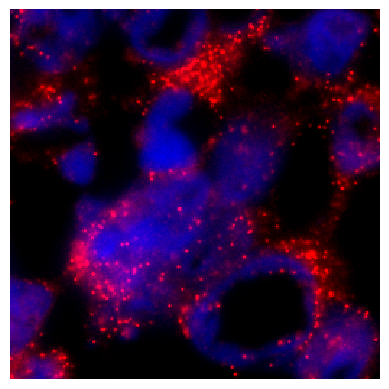

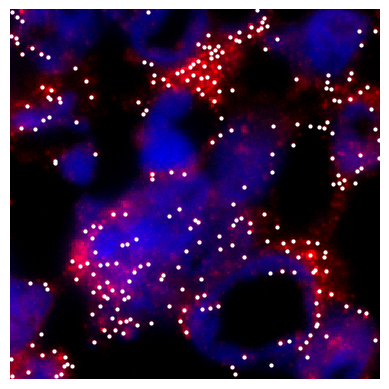

In [54]:
# Load the Piscis test dataset.
test_ds = load_datasets(with_dapi_path / '20191221_183732_211__ChannelDAPI,CY3,A594,CY5,Brightfield_Seq0000_crop1to1407_14Jan2019_CY5_with_dapi.npz', adjustment=None, load_train=False, load_valid=False, load_test=True)['test']
image = test_ds['images'][2]
coord = test_ds['coords'][2]

# Show image of melanoma in mice.
fig, ax = plt.subplots()
ax.imshow(to_rgb(image, 25, 99.5, 25, 100), interpolation='none')
strip_axes(ax)
fig.savefig(panels_path / 'melanoma_mice.pdf')
display(fig)

# Show image of melanoma in mice with ground truth annotations.
ax.plot(coord[:, 1], coord[:, 0], '.', c='white', markersize=4)
fig.savefig(panels_path / 'melanoma_mice_ground_truth.pdf')

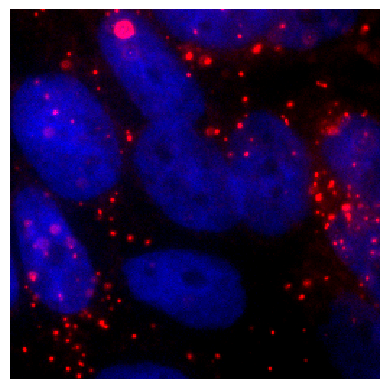

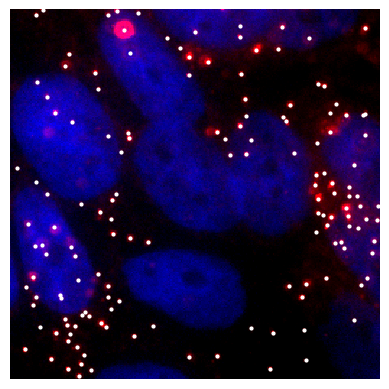

In [55]:
# Load the Piscis test dataset.
test_ds = load_datasets(with_dapi_path / 'ChannelDAPI,A594,YFP,Brightfield_Seq0000_A594_with_dapi.npz', adjustment=None, load_train=False, load_valid=False, load_test=True)['test']
image = test_ds['images'][4]
coord = test_ds['coords'][4]

# Show image of lung cancer.
fig, ax = plt.subplots()
ax.imshow(to_rgb(image, 25, 99.5, 25, 100), interpolation='none')
strip_axes(ax)
fig.savefig(panels_path / 'lung_cancer.pdf')
display(fig)

# Show image of lung cancer with ground truth annotations.
ax.plot(coord[:, 1], coord[:, 0], '.', c='white', markersize=4)
fig.savefig(panels_path / 'lung_cancer_ground_truth.pdf')

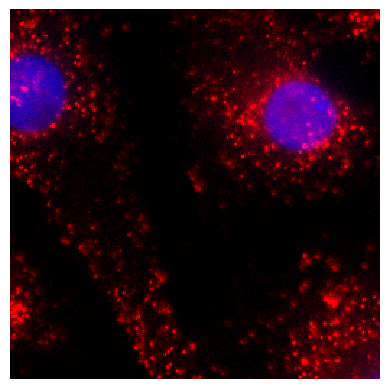

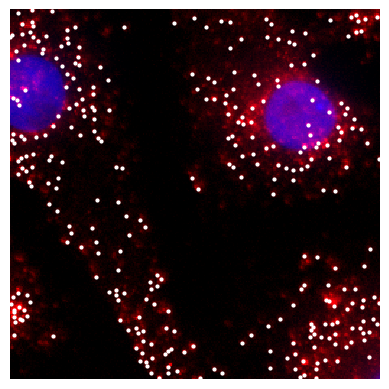

In [56]:
# Load the Piscis test dataset.
test_ds = load_datasets(with_dapi_path / '20220612_101953_317__Well2_ChannelDAPI,CY3,A594,Brightfield_Seq0001_CY3_with_dapi.npz', adjustment=None, load_train=False, load_valid=False, load_test=True)['test']
image = test_ds['images'][4]
coord = test_ds['coords'][4]

# Show image of macrophages.
fig, ax = plt.subplots()
ax.imshow(to_rgb(image, 25, 99.5, 25, 100), interpolation='none')
strip_axes(ax)
fig.savefig(panels_path / 'macrophages.pdf')
display(fig)

# Show image of macrophages with ground truth annotations.
ax.plot(coord[:, 1], coord[:, 0], '.', c='white', markersize=4)
fig.savefig(panels_path / 'macrophages_ground_truth.pdf')